In [1]:
# importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
import seaborn as sns

In [2]:
# montando drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# importando base de dados
filePath = '/content/drive/My Drive/Process Quality Control - PLS project'
fileName = 'process_data.csv'
data = pd.read_csv(os.path.join(filePath, fileName))
data.head()

,solutionA_inletFlowRate,water_inletFlowRate,solutionB_inletFlowRate,componentA_inletConcentration,componentB_inletConcentration,solutionA_inletTemperature,water_inletTemperature,solutionB_inletTemperature,componentA_outletConcentration,componentB_outletConcentration,componentC_outletConcentration,outletTemperature
0,2.488026,7.022645,0.493385,7.415100,12.313350,29.232410,10.161989,29.204568,1.747784,0.414548,0.192728,96.089927
1,2.564250,7.210281,0.521194,7.001721,12.246920,30.321235,9.813532,29.937081,1.649414,0.431103,0.188865,95.193304
2,2.578252,7.356546,0.530302,7.039666,11.964474,29.647262,9.939467,30.877037,1.648039,0.433679,0.172601,88.922935
3,2.438043,6.534329,0.492974,7.097230,12.032390,29.074167,10.126576,30.156679,1.716432,0.403386,0.223285,108.955373
4,2.222003,6.377055,0.496884,7.185610,11.724253,31.573436,10.024570,28.878612,1.637008,0.403802,0.236659,114.179174


In [4]:
# checando informações dos dados
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   solutionA_inletFlowRate         5000 non-null   float64
 1   water_inletFlowRate             5000 non-null   float64
 2   solutionB_inletFlowRate         5000 non-null   float64
 3   componentA_inletConcentration   5000 non-null   float64
 4   componentB_inletConcentration   5000 non-null   float64
 5   solutionA_inletTemperature      5000 non-null   float64
 6   water_inletTemperature          5000 non-null   float64
 7   solutionB_inletTemperature      5000 non-null   float64
 8   componentA_outletConcentration  5000 non-null   float64
 9   componentB_outletConcentration  5000 non-null   float64
 10  componentC_outletConcentration  5000 non-null   float64
 11  outletTemperature               5000 non-null   float64
dtypes: float64(12)
memory usage: 468.9

Verifica-se que todos os dados obtidos são da categoria númerico e que também não há valores nulos presentes.

O conjunto de dados é constituído de 11 variáveis de processo, sendo 7 delas são variáveis de controle (*input*) e as 4 restantes, variáveis de saída (*output*).

São variáveis de entrada:
- vazão de solução A
- vazão de água
- vazão de solução B
- concentração de entrada do componente A
- concentração de entrada do componente B
- temperatura de entrada da solução A
- temperatura de entrada de água
- temperatura de entrada da solução B

São variáveis de saída:
- concentração de saída do componente A
- concentração de saída do componente B
- concentração de saída do componente C
- temperatura de saída


## **1. Objetivo do Estudo**

No processo em estudo, observa-se grande variação da conversão obtida no reator. Desta forma, deseja-se treinar um modelo que possa identificar anomalias de processo e assim, corrigir o processo para garantir estabilidade.
No entanto, existem muitas variáveis de saída que precisam ser controladas, pois cada uma possui sua importância para o processo produtivo. Para isso, deve ser construída uma metodologia que permita a identificação de pontos fora de controle estatístico e propor a correção do processo.



### **1.1. Objetivos Específicos**

Como objetivos específicos desse trabalho, elencam-se:

- realizar a análise preliminar de dados para identificar *outliers* e valores com erros de medidas
- realizar a análise exploratória dos dados para entender as correlações existentes entre as variáveis de processo
- avaliar o processo produtivo do ponto de vista do controle estatístico de processo.
- criar um modelo preditivo das variáveis de saída do processo que permitam a realização da previsão dos valores de forma a criar uma forma de garantir o controle de qualidade das variáveis de interesse usando somente variáveis que possam ser facilmente medidas na entrada ou durante o processo.
- validar o modelo preditivo para realizar predições de variáveis necessárias ao controle de qualidade
- criar uma estratégia de ação de controle com base nas respostas dos modelos preditivos criados.


In [5]:
# criação das colunas de indicadores
data['X'] = (data['componentB_inletConcentration']-data['componentB_outletConcentration'])/data['componentB_inletConcentration']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   solutionA_inletFlowRate         5000 non-null   float64
 1   water_inletFlowRate             5000 non-null   float64
 2   solutionB_inletFlowRate         5000 non-null   float64
 3   componentA_inletConcentration   5000 non-null   float64
 4   componentB_inletConcentration   5000 non-null   float64
 5   solutionA_inletTemperature      5000 non-null   float64
 6   water_inletTemperature          5000 non-null   float64
 7   solutionB_inletTemperature      5000 non-null   float64
 8   componentA_outletConcentration  5000 non-null   float64
 9   componentB_outletConcentration  5000 non-null   float64
 10  componentC_outletConcentration  5000 non-null   float64
 11  outletTemperature               5000 non-null   float64
 12  X                               50

## **2. Análise Exploratória de Dados**

In [6]:
def control_chart(data, var_name, n = 5):
  # função que plota as cartas de controle da média e amplitudes para determinado
  # processo, com base em uma amostragem de n pontos por minuto

  to_monitor = pd.DataFrame(data[var_name], columns=[var_name])

  # definição do dicionário de valores de constantes
  d2_dict = {2: 1.128, 3: 1.693, 4: 2.059, 5: 2.326, 6: 2.534, 7: 2.704,
            8: 2.847, 9: 2.970, 10: 3.078, 11: 3.173, 12: 3.258, 13: 3.336,
            14: 3.407, 15: 3.472}
  d3_dict = {2: 0.853, 3: 0.888, 4: 0.880, 5: 0.864, 6: 0.848, 7: 0.833,
            8: 0.820, 9: 0.808, 10: 0.797, 11: 0.787, 12: 0.778, 13: 0.770,
            14: 0.763, 15: 0.756}

  # agrupamento dos monitoramentos e cálculo dos valores da carta
  to_monitor_mean = to_monitor.groupby(to_monitor.index//n).agg({var_name:'mean'})
  to_monitor_max = to_monitor.groupby(to_monitor.index//n).agg({var_name:'max'})
  to_monitor_min = to_monitor.groupby(to_monitor.index//n).agg({var_name:'min'})

  to_monitor_full = pd.concat([to_monitor_mean, to_monitor_max], axis = 1)
  to_monitor_full = pd.concat([to_monitor_full, to_monitor_min], axis = 1)

  to_monitor_full.columns = ['Avg','Max','Min']
  to_monitor_full['Amp'] = to_monitor_full['Max'] - to_monitor_full['Min']

  to_monitor_full.drop(['Max','Min'], axis = 1, inplace = True)

  # construção das cartas de controle - carta de amplitude
  d2 = d2_dict[n]
  d3 = d3_dict[n]
  R_bar = to_monitor_full['Amp'].mean()
  R_sigma = R_bar*(d3/d2)
  LSC_R = R_bar + 3*R_sigma
  LIC_R = R_bar - 3*R_sigma

  # construção das cartas de controle - carta de médias
  A2 = (3*R_bar)/(d2*np.sqrt(n))
  X_bar = to_monitor_full['Avg'].mean()
  LSC_X = X_bar + (A2*R_bar)
  LIC_X = X_bar - (A2*R_bar)

  plt.figure(figsize=(13,15))
  plt.subplot(2,1,1)
  plt.plot(to_monitor_full['Amp'], 'k.-')
  plt.axhline(y = LSC_R, color = 'r', linestyle = '--')
  plt.axhline(y = LIC_R, color = 'r', linestyle = '--')
  plt.axhline(y = R_bar, color = 'r', linestyle = '--')
  plt.ylabel(var_name, fontsize = 16)
  plt.xlabel('Amostras', fontsize = 16)
  plt.title('Carta de Controle - Amplitudes - ' + var_name, fontsize = 20)
  plt.grid()

  plt.subplot(2,1,2)
  plt.plot(to_monitor_full['Avg'], 'k.-')
  plt.axhline(y = LSC_X, color = 'r', linestyle = '--')
  plt.axhline(y = LIC_X, color = 'r', linestyle = '--')
  plt.axhline(y = X_bar, color = 'r', linestyle = '--')
  plt.ylabel(var_name, fontsize = 16)
  plt.xlabel('Amostras', fontsize = 16)
  plt.title('Carta de Controle - Médias - ' + var_name, fontsize = 20)
  plt.grid()

  plt.show()

  #retornar os valores calculados de limites estatísticos
  results = {'LIC_R': LIC_R, 'R_bar': R_bar,'LSC_R': LSC_R, 
             'LIC_X': LIC_X, 'X_bar': X_bar, 'LSC_X': LSC_X}

  return results

In [7]:
# construção de histogramas e boxplots
def hist_boxplot(data, var_name):
  # função que cria gráficos de histograma e boxplot para uma variável selecionada
  to_monitor = pd.DataFrame(data[var_name], columns=[var_name])

  # cálculo de parâmetros para construção de linhas verticais
  avg = to_monitor[var_name].mean()
  std = to_monitor[var_name].std()

  x1_vline = avg - 3*std
  x2_vline = avg + 3*std

  # construção do histograma e do boxplot
  fig = plt.figure(figsize=(20,10))
  ax1 = fig.add_subplot(1,2,1)
  sns.histplot(to_monitor[var_name], stat = 'density', kde = True, element = 'step', alpha = 0.7)
  ax1.axvline(x = x1_vline, color = 'r', linestyle = '--')
  ax1.axvline(x = x2_vline, color = 'r', linestyle = '--')
  ax1.set_ylabel('Densidade', fontsize = 16)
  ax1.set_xlabel(var_name, fontsize = 16)
  ax1.set_title('Histograma - ' + var_name + '\nLinhas para +- 3 Desvios Padrão', fontsize = 20)
  
  ax2 = fig.add_subplot(1,2,2)
  sns.boxplot(x = to_monitor[var_name], orient = 'h', color = 'g')
  ax2.axvline(x = x1_vline, color = 'r', linestyle = '--')
  ax2.axvline(x = x2_vline, color = 'r', linestyle = '--')
  ax2.set_xlabel(var_name, fontsize = 16)
  ax2.set_title('Boxplot - ' + var_name+ '\nLinhas para +- 3 Desvios Padrão', fontsize = 20)
  
  plt.suptitle('Análise de Variabilidade - ' + var_name, size = 22)

Antes porém de construir as cartas de controle e histogramas, vamos verificar se existem erros de entradas de dados no conjunto ou se existem dados faltantes.

In [8]:
# checando se existem valores nulos
data.isna().sum()

solutionA_inletFlowRate           0
water_inletFlowRate               0
solutionB_inletFlowRate           0
componentA_inletConcentration     0
componentB_inletConcentration     0
solutionA_inletTemperature        0
water_inletTemperature            0
solutionB_inletTemperature        0
componentA_outletConcentration    0
componentB_outletConcentration    0
componentC_outletConcentration    0
outletTemperature                 0
X                                 0
dtype: int64

Não existem dados faltantes. Todas as colunas e linhas de dados são preenchidas com valores válidos. Vamos verificar a presença de valores extremos em cada variável.

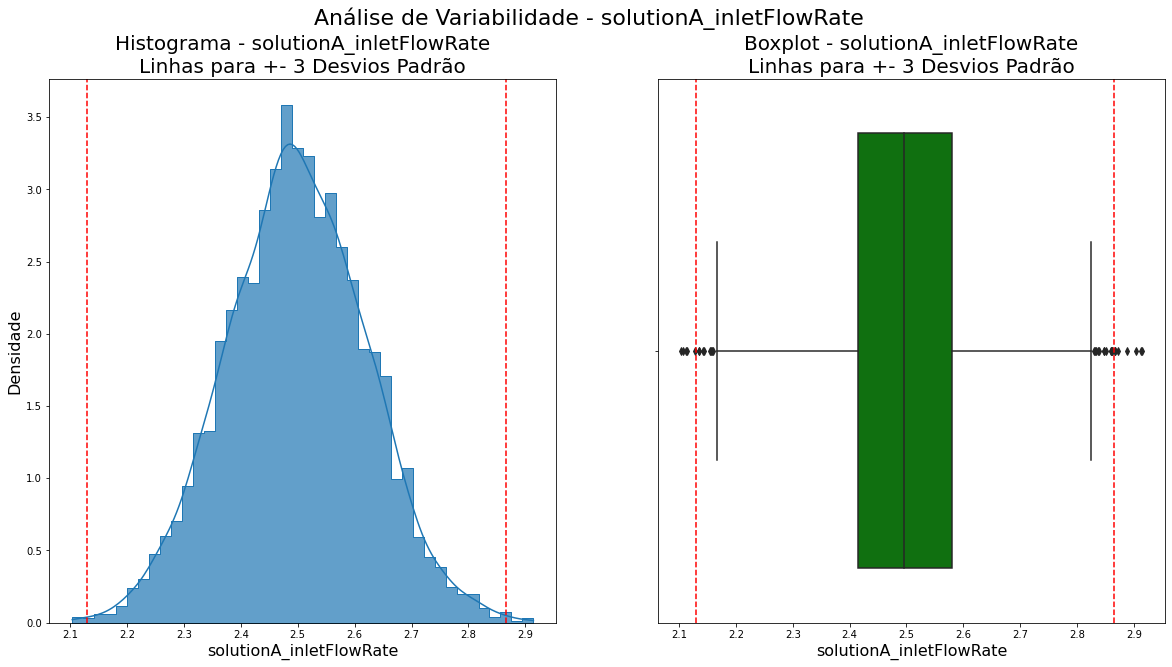

In [9]:
var_name = data.columns[0]
hist_boxplot(data, var_name)

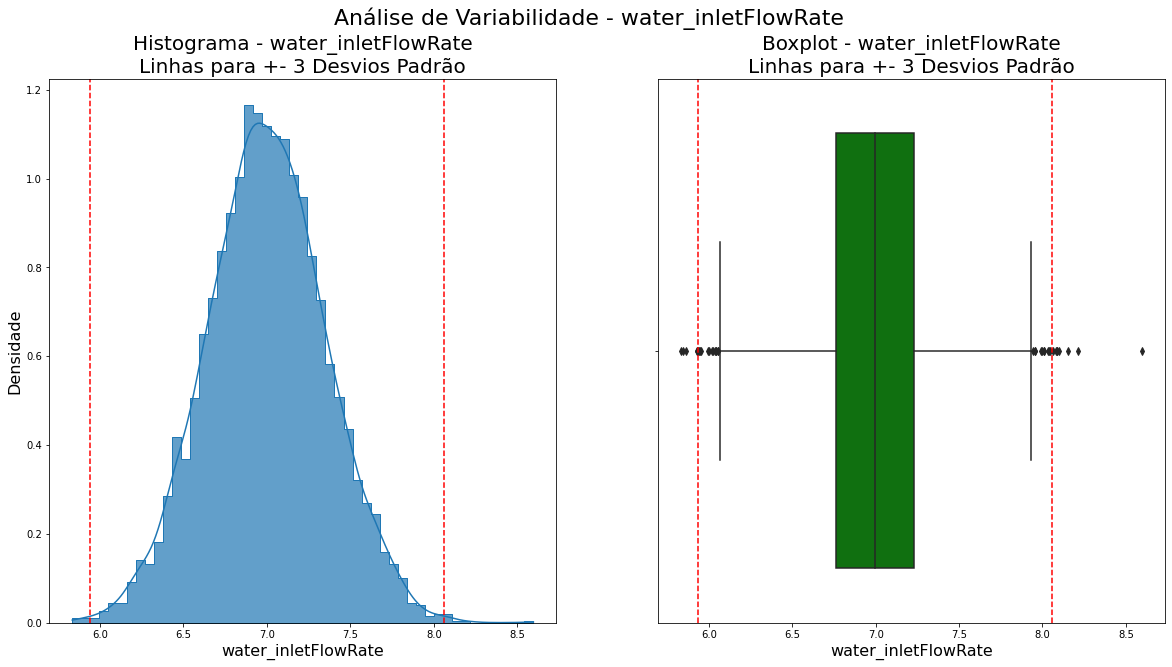

In [10]:
var_name = data.columns[1]
hist_boxplot(data, var_name)

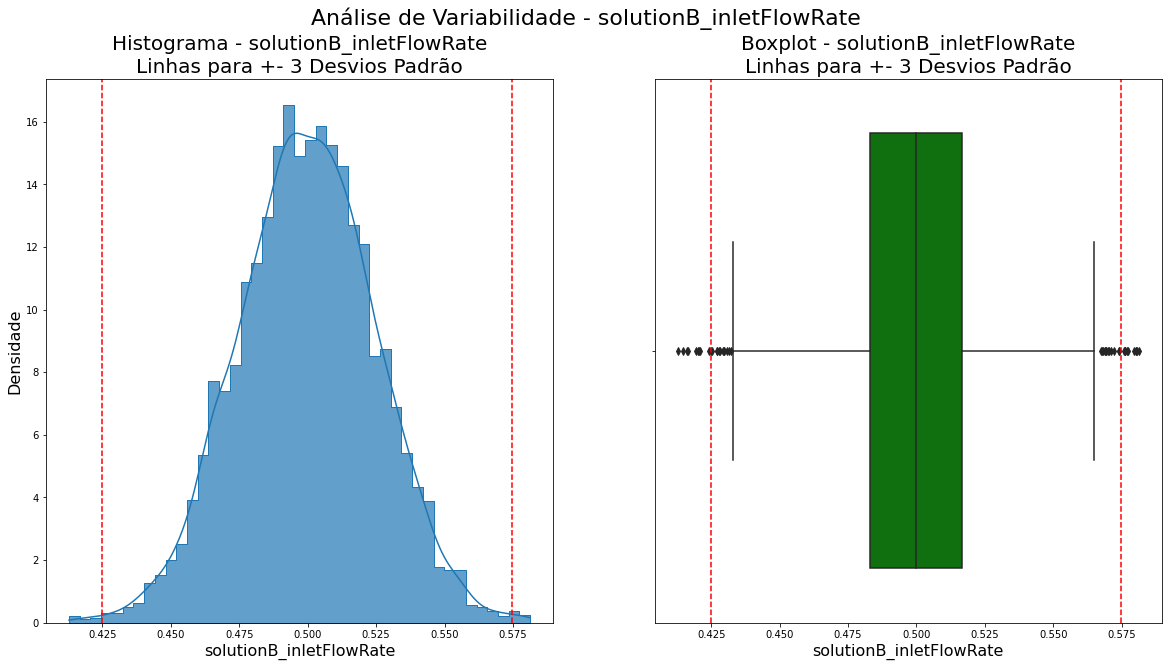

In [11]:
var_name = data.columns[2]
hist_boxplot(data, var_name)

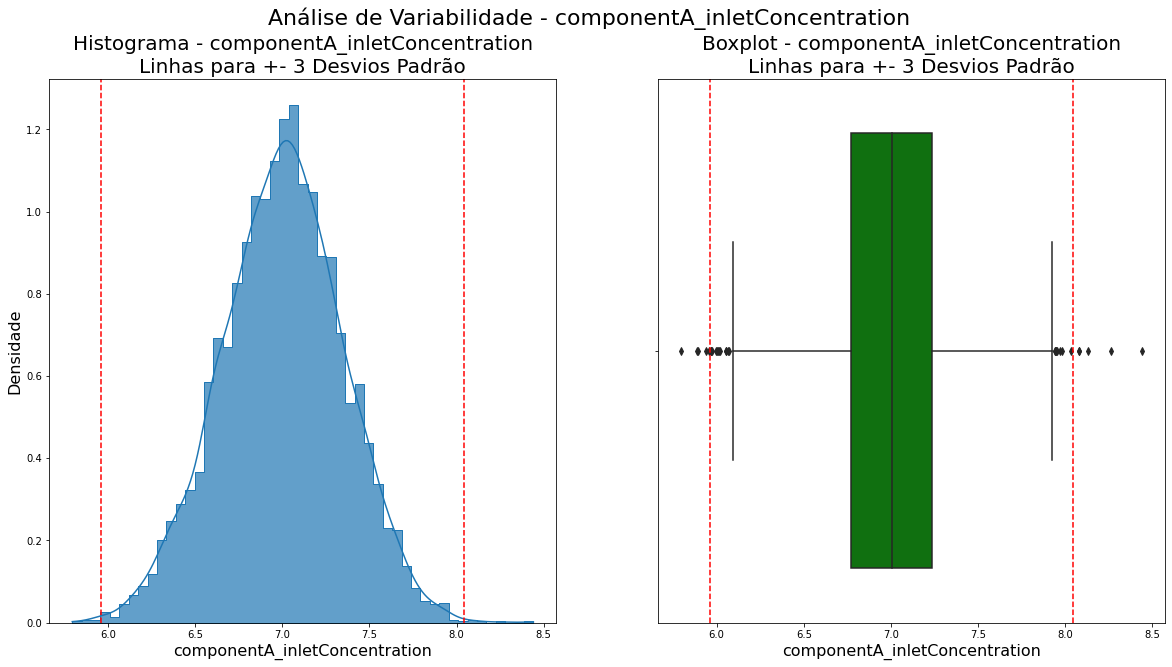

In [12]:
var_name = data.columns[3]
hist_boxplot(data, var_name)

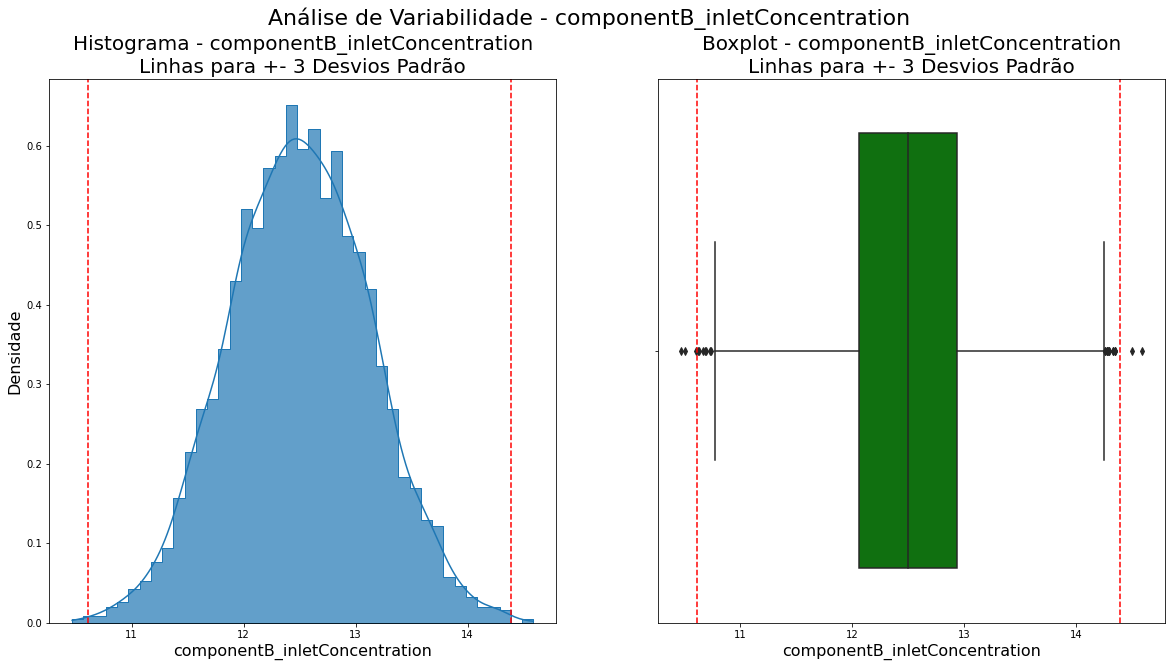

In [13]:
var_name = data.columns[4]
hist_boxplot(data, var_name)

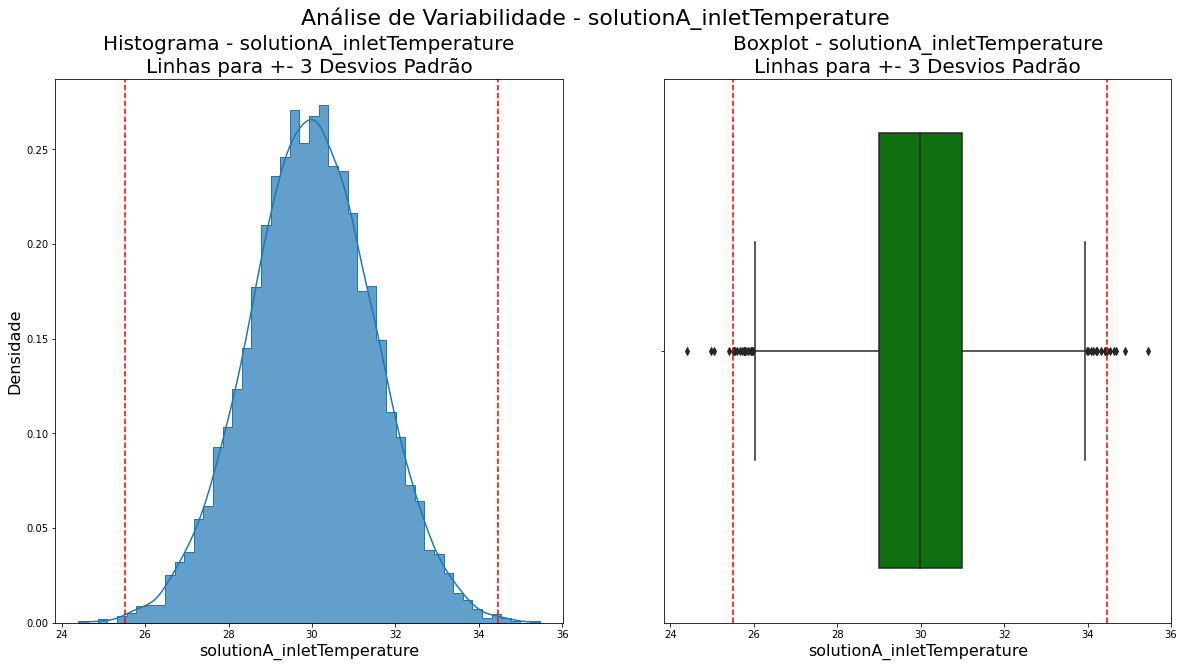

In [14]:
var_name = data.columns[5]
hist_boxplot(data, var_name)

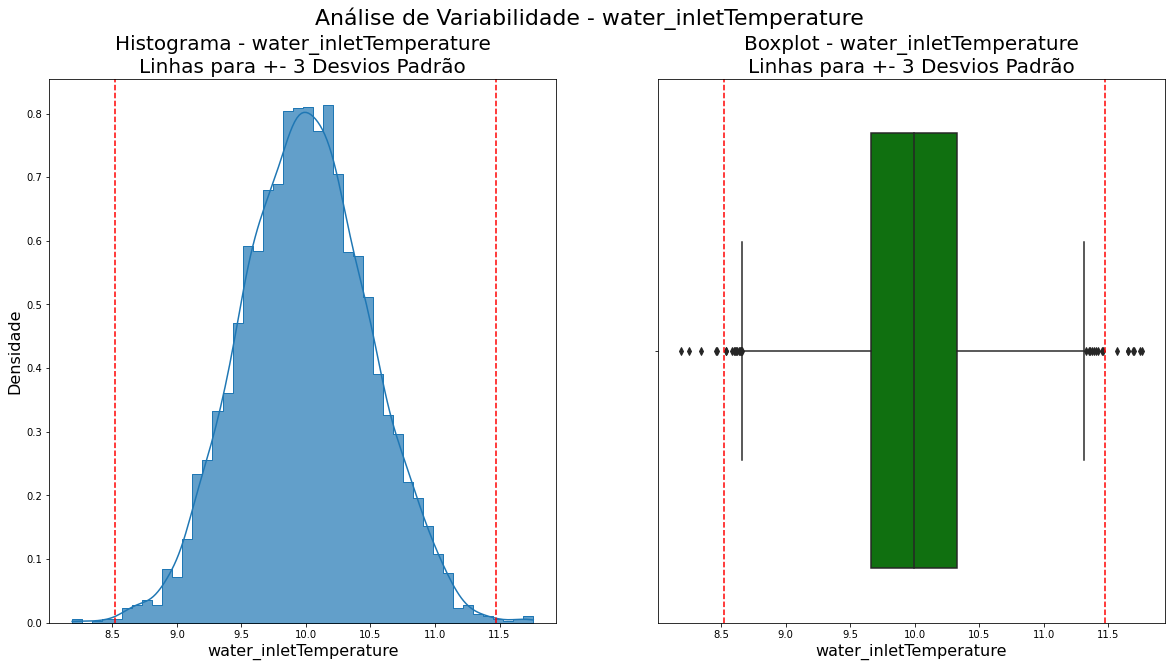

In [15]:
var_name = data.columns[6]
hist_boxplot(data, var_name)

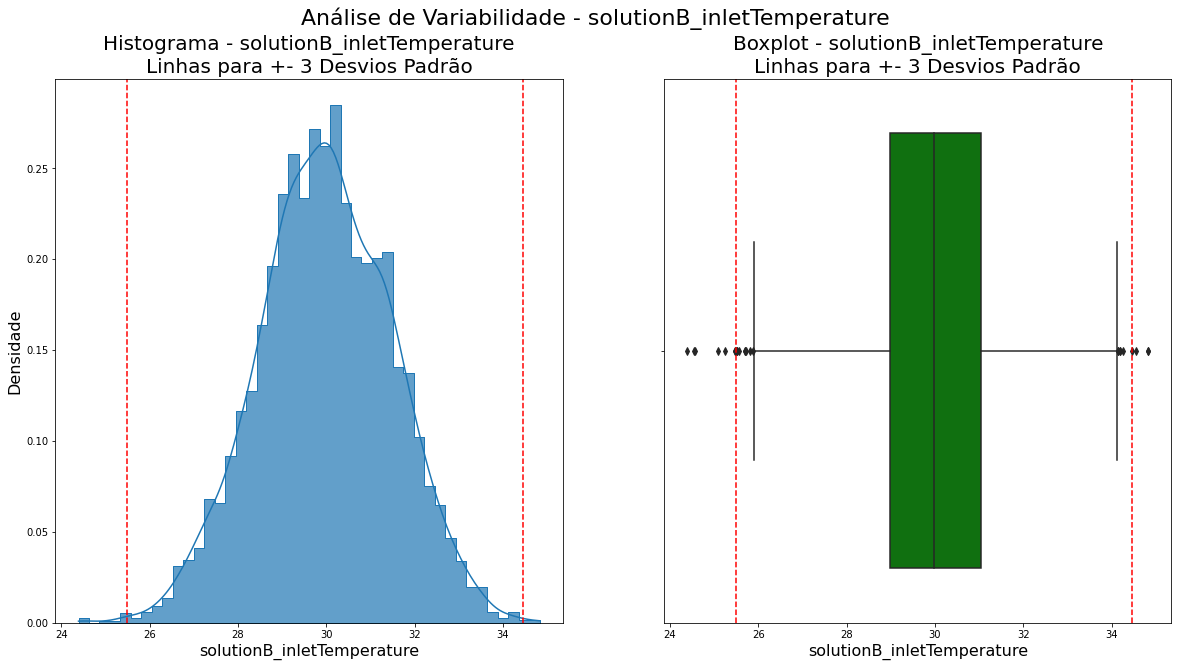

In [16]:
var_name = data.columns[7]
hist_boxplot(data, var_name)

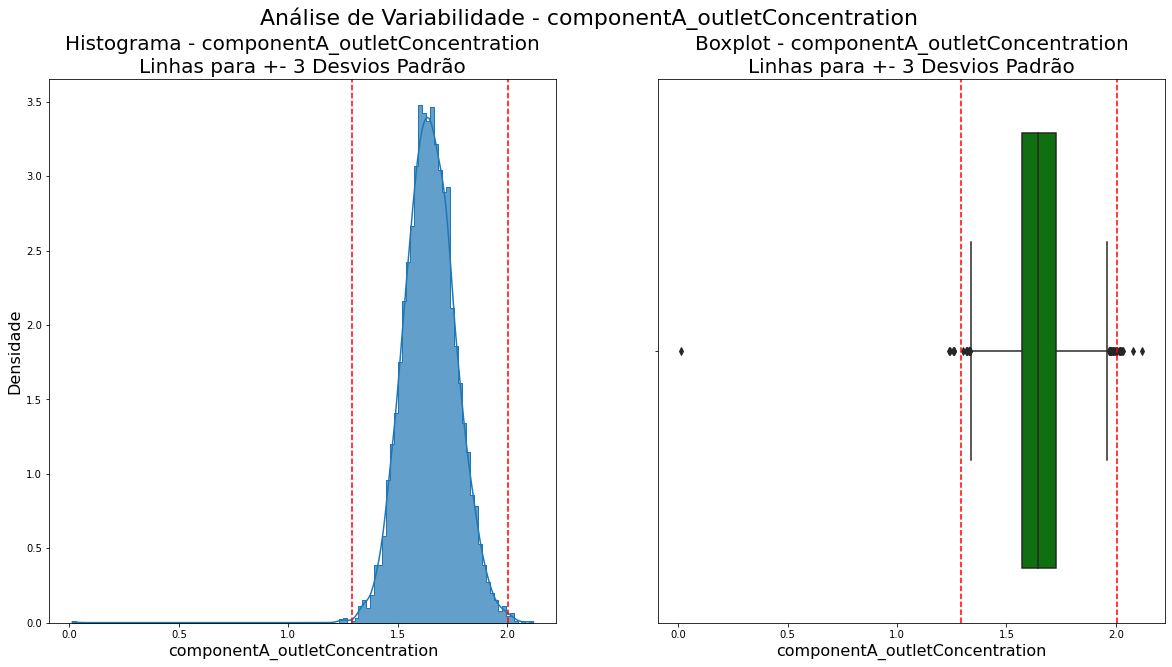

In [17]:
var_name = data.columns[8]
hist_boxplot(data, var_name)

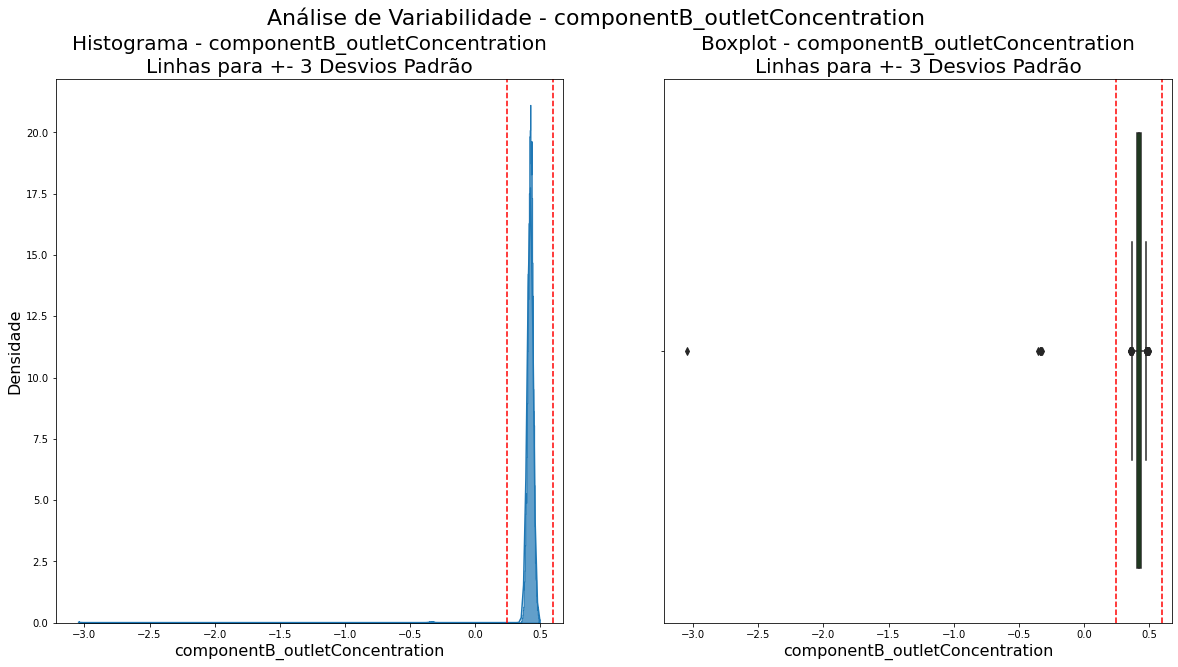

In [18]:
var_name = data.columns[9]
hist_boxplot(data, var_name)

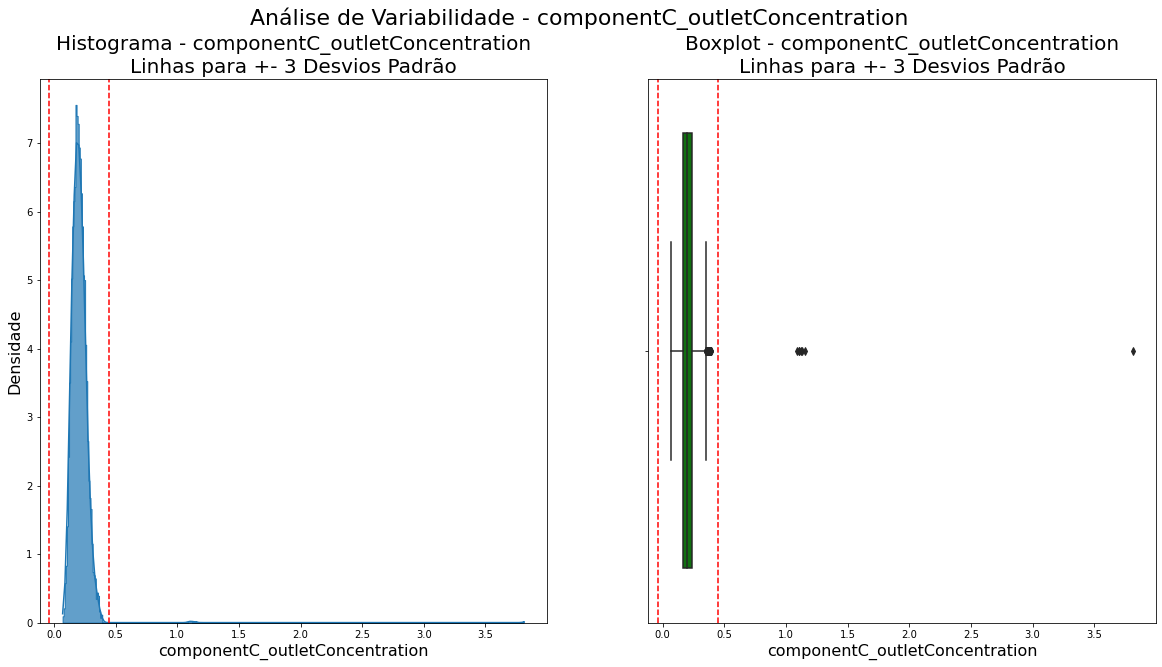

In [19]:
var_name = data.columns[10]
hist_boxplot(data, var_name)

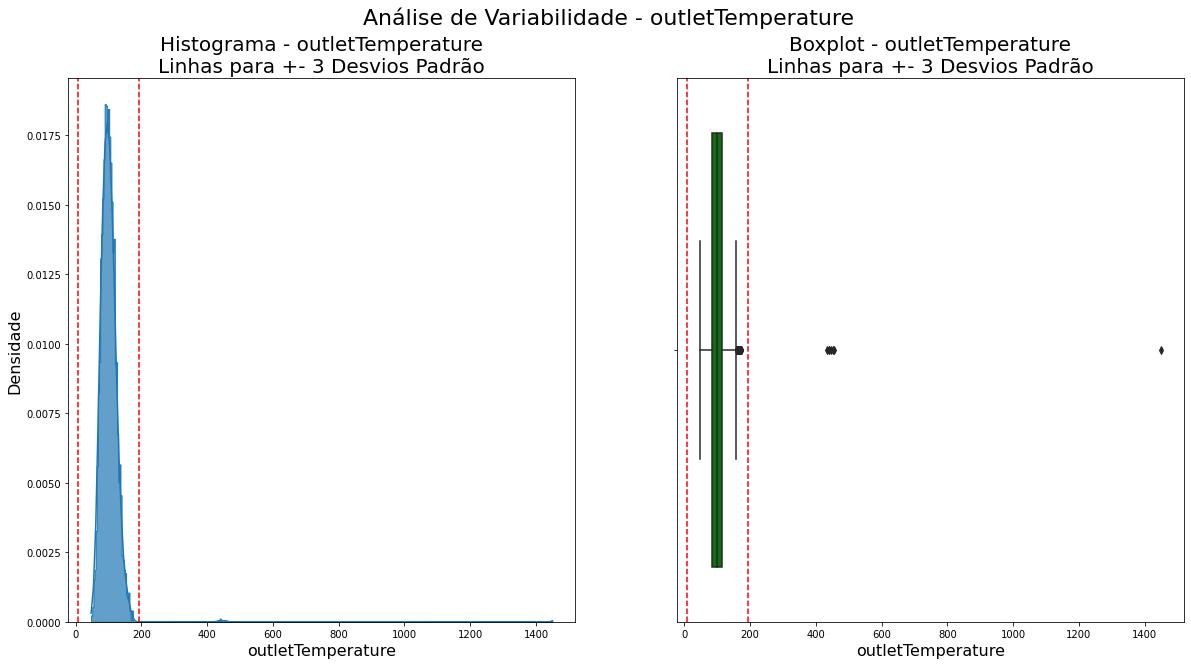

In [20]:
var_name = data.columns[11]
hist_boxplot(data, var_name)

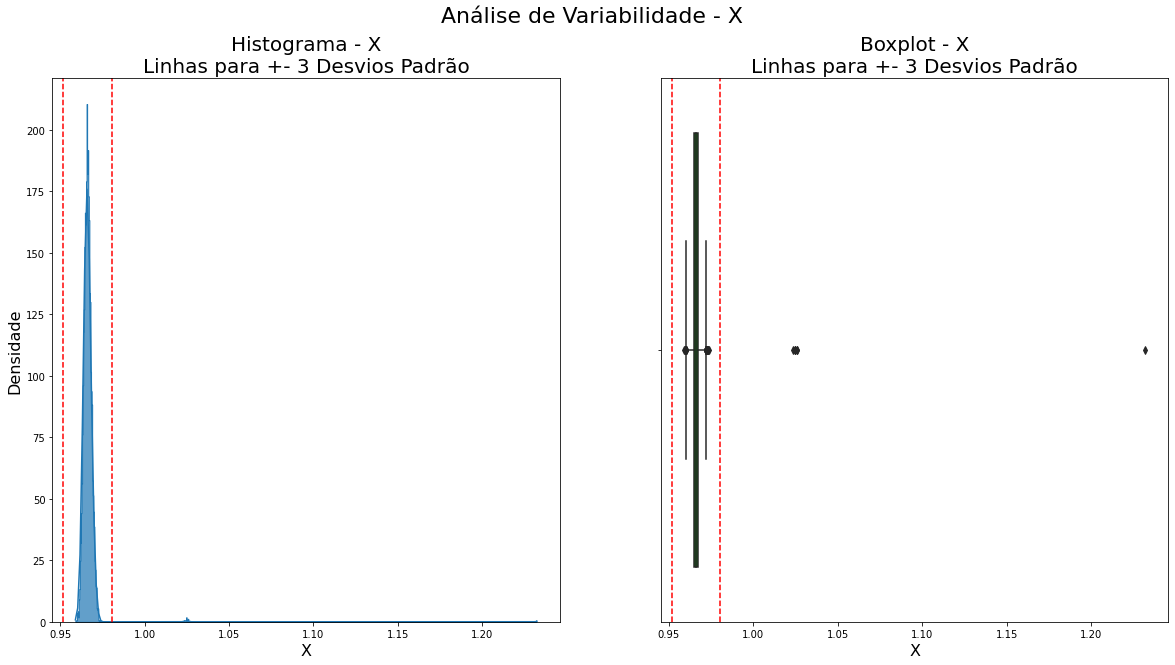

In [21]:
var_name = data.columns[12]
hist_boxplot(data, var_name)

Como se pode verificar, todas as variáveis possuem *outliers* na sua distribuição, inclusive alguns desses valores distorcendo bastante a distribuição dos dados.

É necessário realizar o tratamento dos dados. Em discussão com o time de negócios, foi verificado que os dados fora dos limites de +- desvios padrão podem ser retirados do dataset, visto que não refletem operações normais da planta.

In [22]:
def data_treatment(data, var_name):

  # identificando calculando os parâmetros necessários para eliminação de dados
  avg = data[var_name].mean()
  sd = data[var_name].std()

  # calculando limites superior e inferior
  sup = avg + 3*sd
  inf = avg - 3*sd

  # contagem da quantidade original de linhas
  n_before = data.shape[0]

  # eliminação de dados 
  data = data.loc[(data[var_name] >= inf) & (data[var_name] <= sup)]

  # contagem da quantidade final de linhas
  n_after = data.shape[0]

  print('Dataset Original: %d linhas'%n_before)
  print('Dataset Final: %d linhas'%n_after)
  print('Redução: %.2f %%'%((n_before-n_after)*100/n_before))

  return data

Dataset Original: 5000 linhas
Dataset Final: 4988 linhas
Redução: 0.24 %


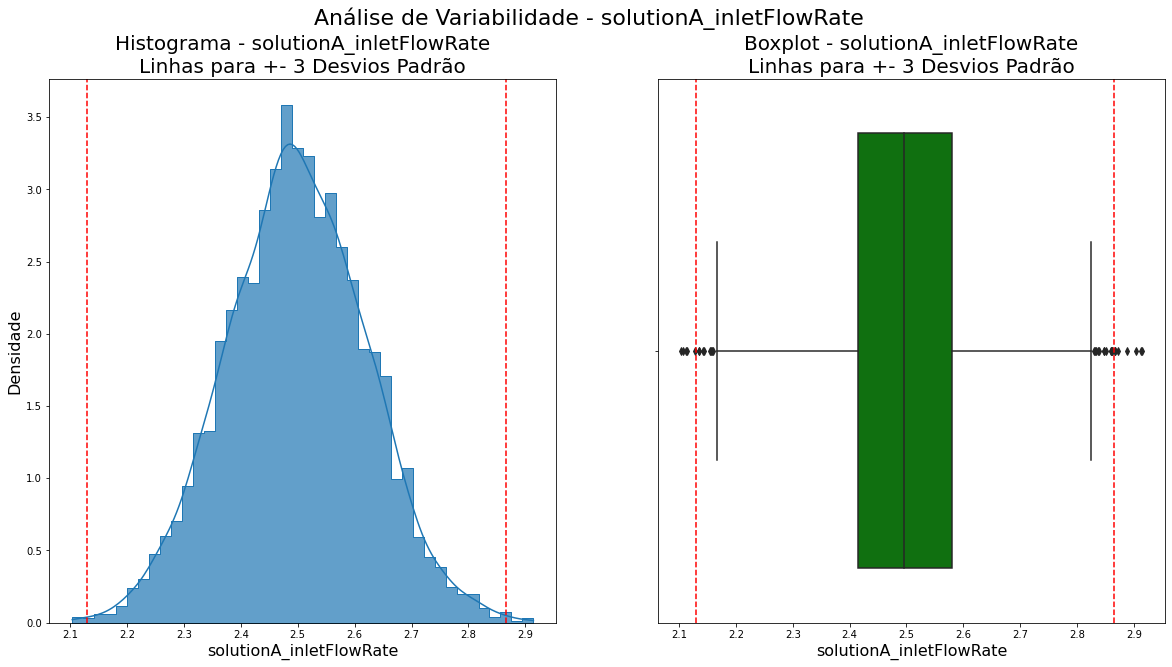

In [23]:
var_name = data.columns[0]
data_t = data_treatment(data, var_name)
hist_boxplot(data, var_name)

In [24]:
# uma vez testada, a função pode ser aplicada para todas as outras colunas da base de dados
columns_list = data.columns

for column in columns_list:
  data_t = data_treatment(data_t, column)

Dataset Original: 4988 linhas
Dataset Final: 4988 linhas
Redução: 0.00 %
Dataset Original: 4988 linhas
Dataset Final: 4974 linhas
Redução: 0.28 %
Dataset Original: 4974 linhas
Dataset Final: 4955 linhas
Redução: 0.38 %
Dataset Original: 4955 linhas
Dataset Final: 4945 linhas
Redução: 0.20 %
Dataset Original: 4945 linhas
Dataset Final: 4940 linhas
Redução: 0.10 %
Dataset Original: 4940 linhas
Dataset Final: 4929 linhas
Redução: 0.22 %
Dataset Original: 4929 linhas
Dataset Final: 4917 linhas
Redução: 0.24 %
Dataset Original: 4917 linhas
Dataset Final: 4906 linhas
Redução: 0.22 %
Dataset Original: 4906 linhas
Dataset Final: 4893 linhas
Redução: 0.26 %
Dataset Original: 4893 linhas
Dataset Final: 4889 linhas
Redução: 0.08 %
Dataset Original: 4889 linhas
Dataset Final: 4870 linhas
Redução: 0.39 %
Dataset Original: 4870 linhas
Dataset Final: 4866 linhas
Redução: 0.08 %
Dataset Original: 4866 linhas
Dataset Final: 4860 linhas
Redução: 0.12 %


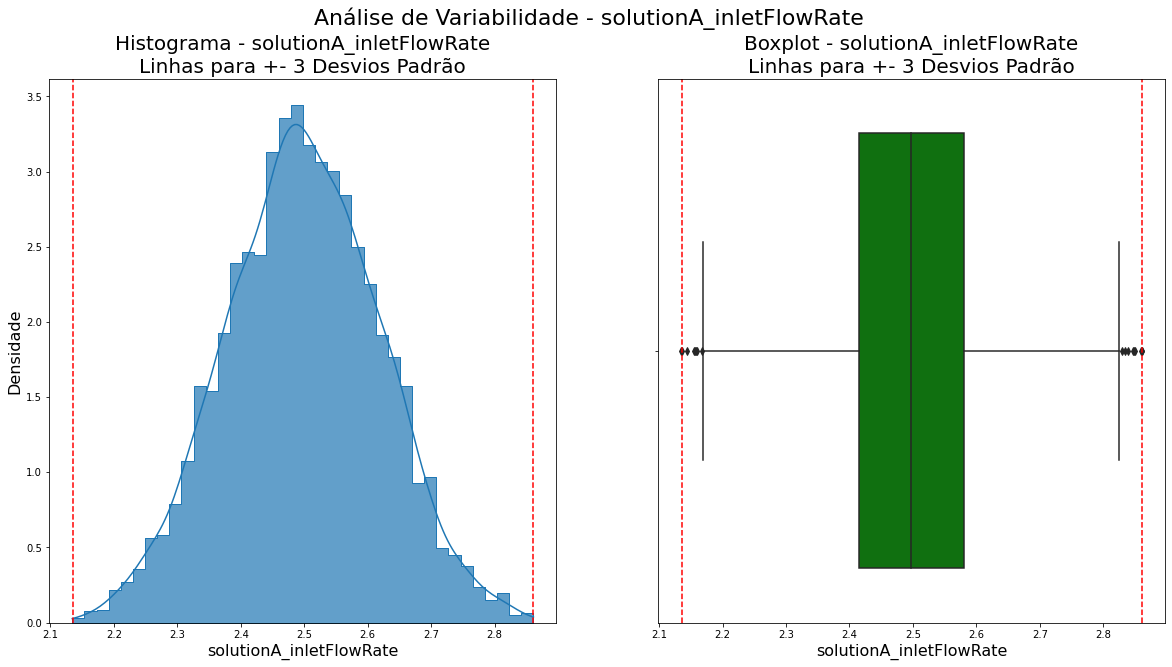

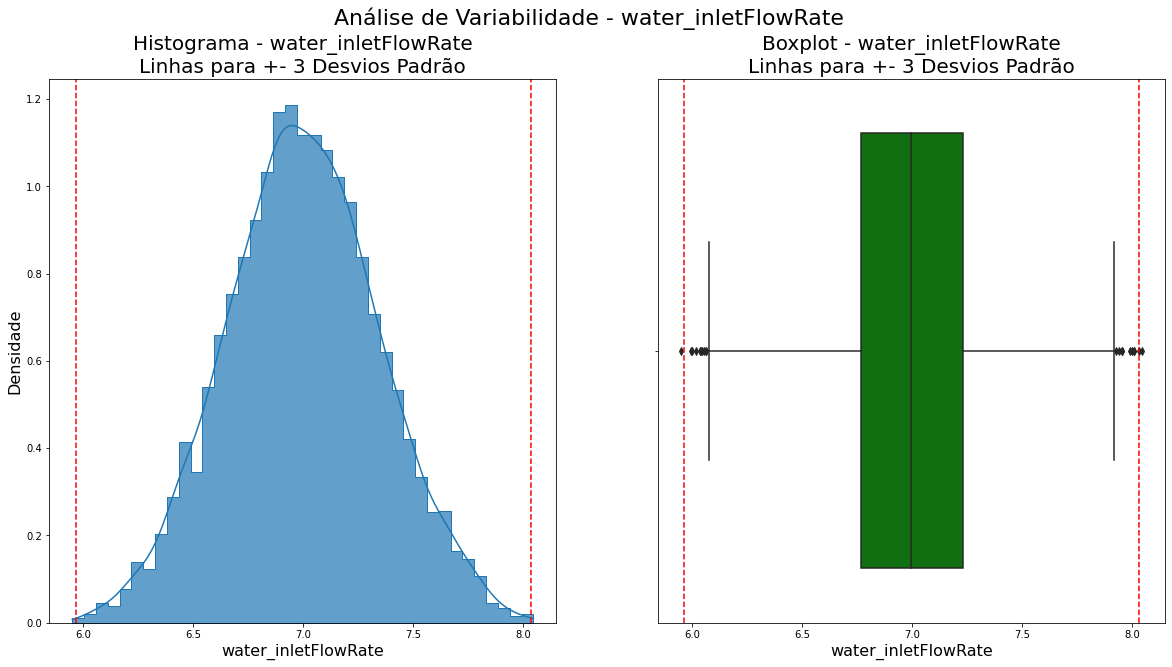

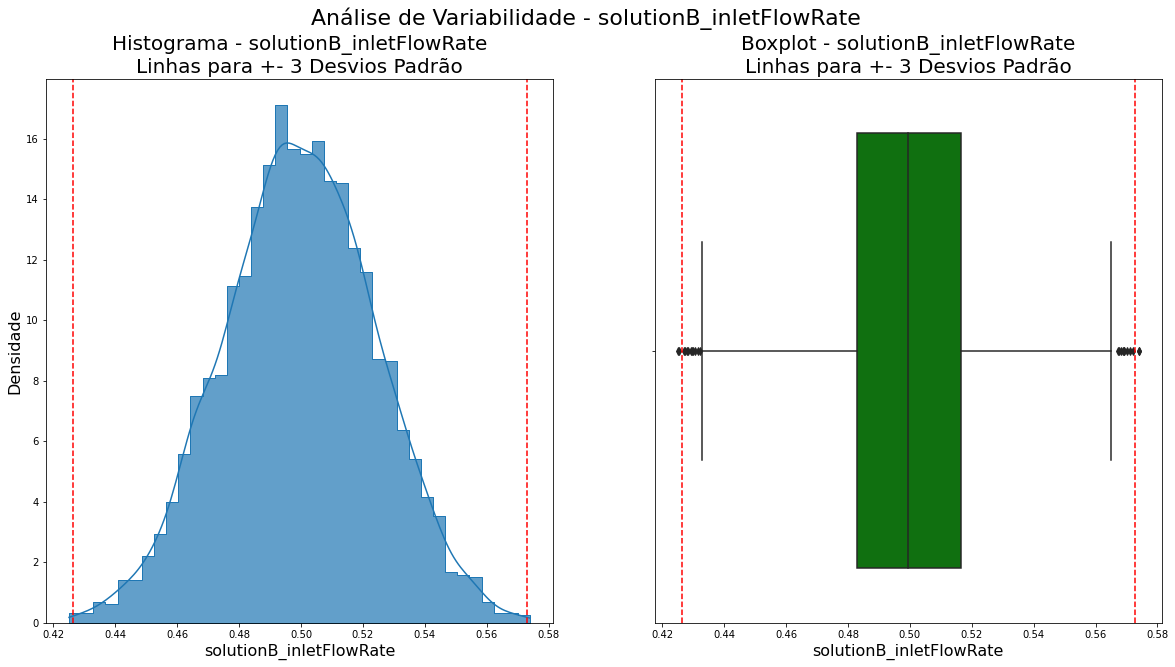

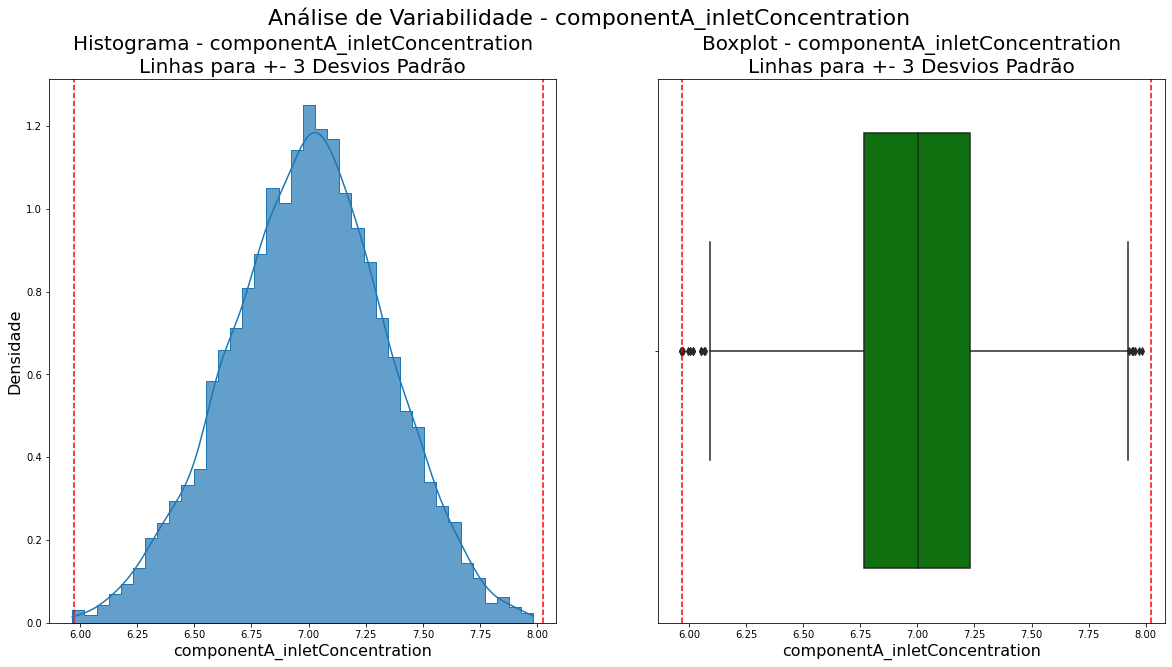

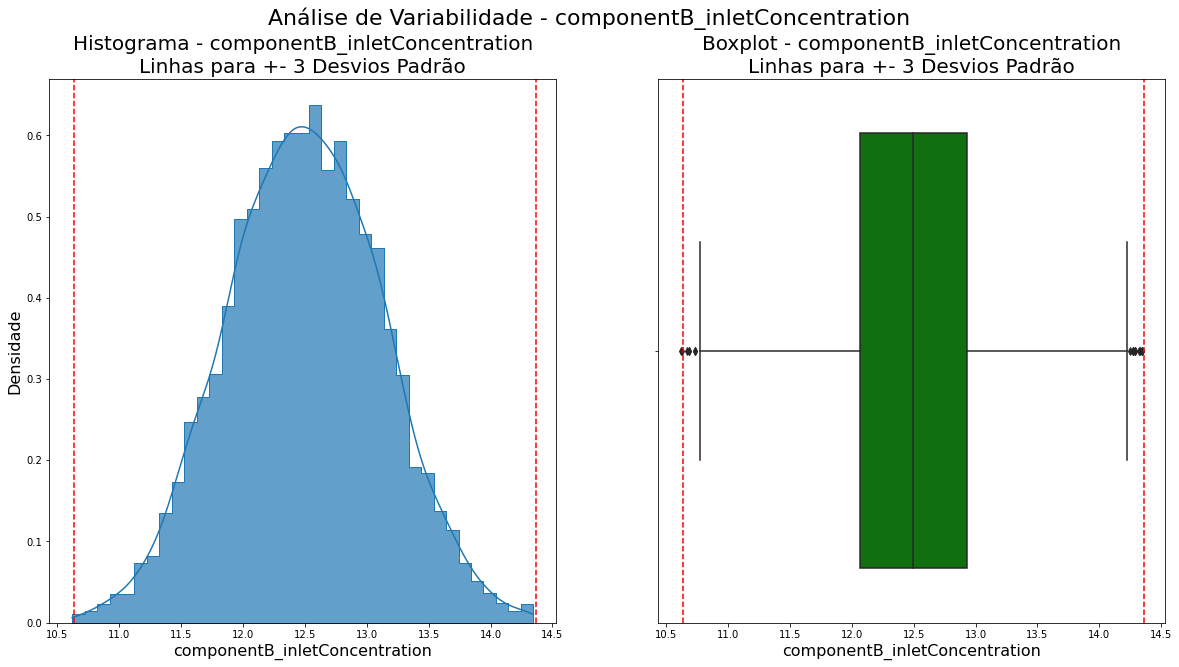

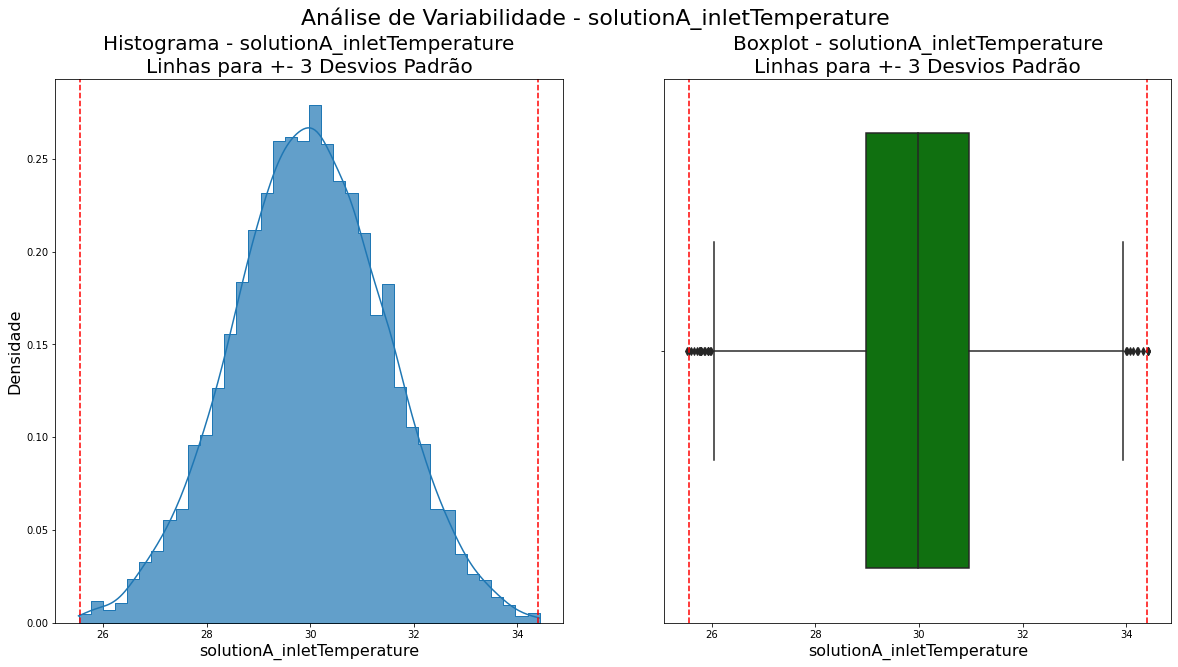

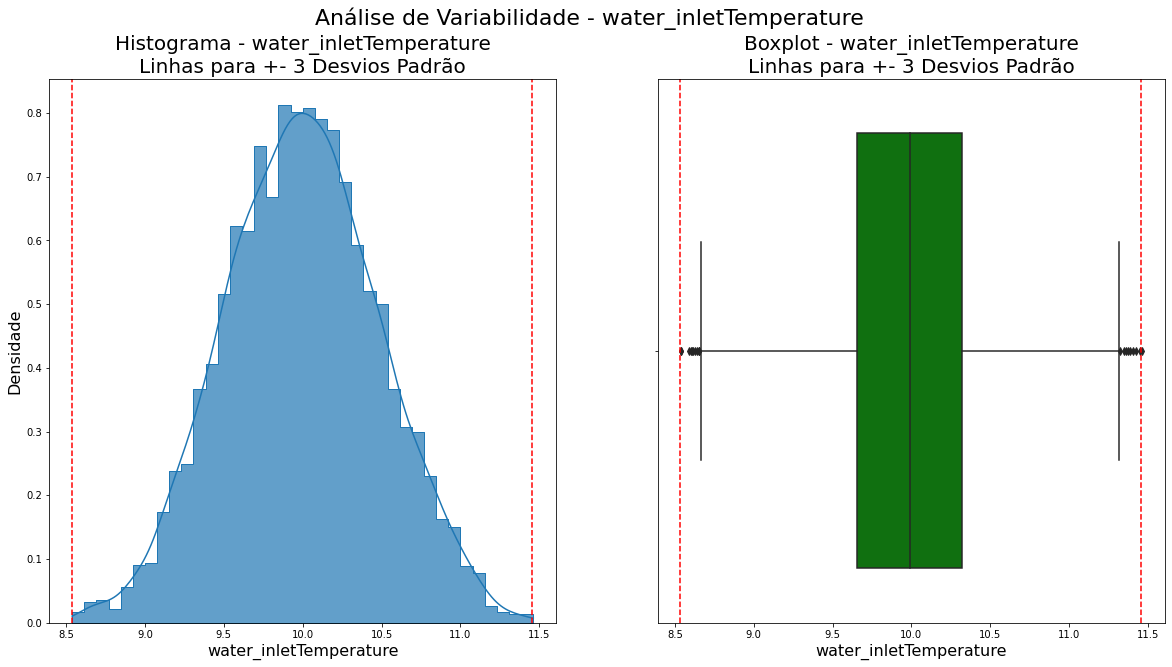

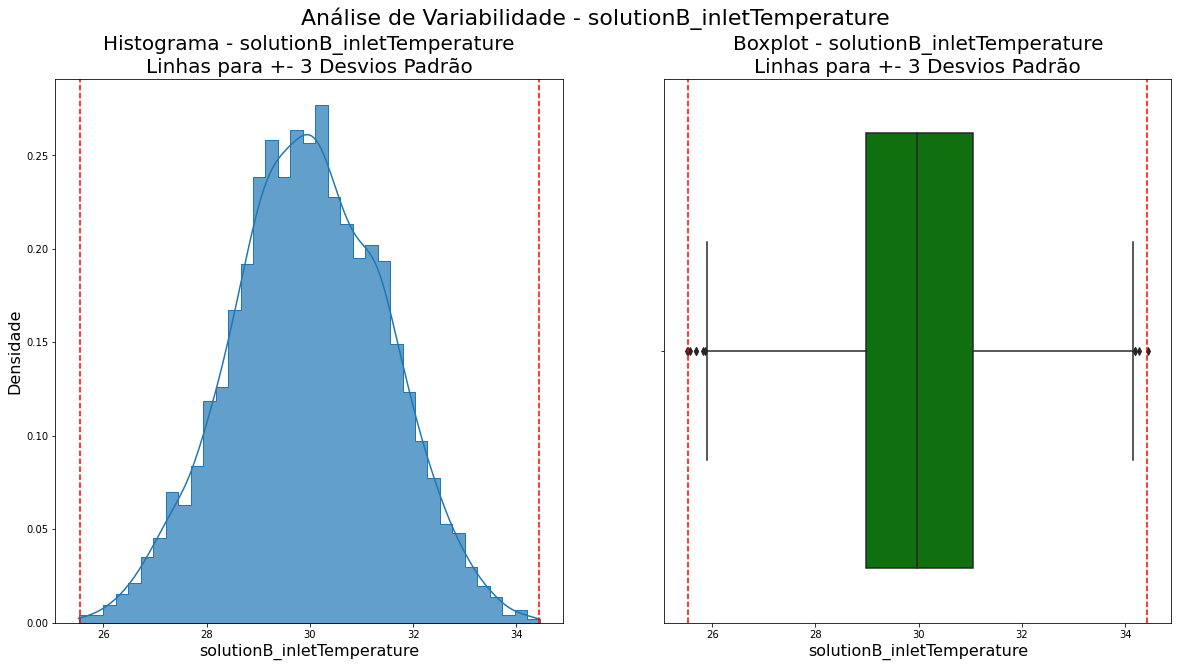

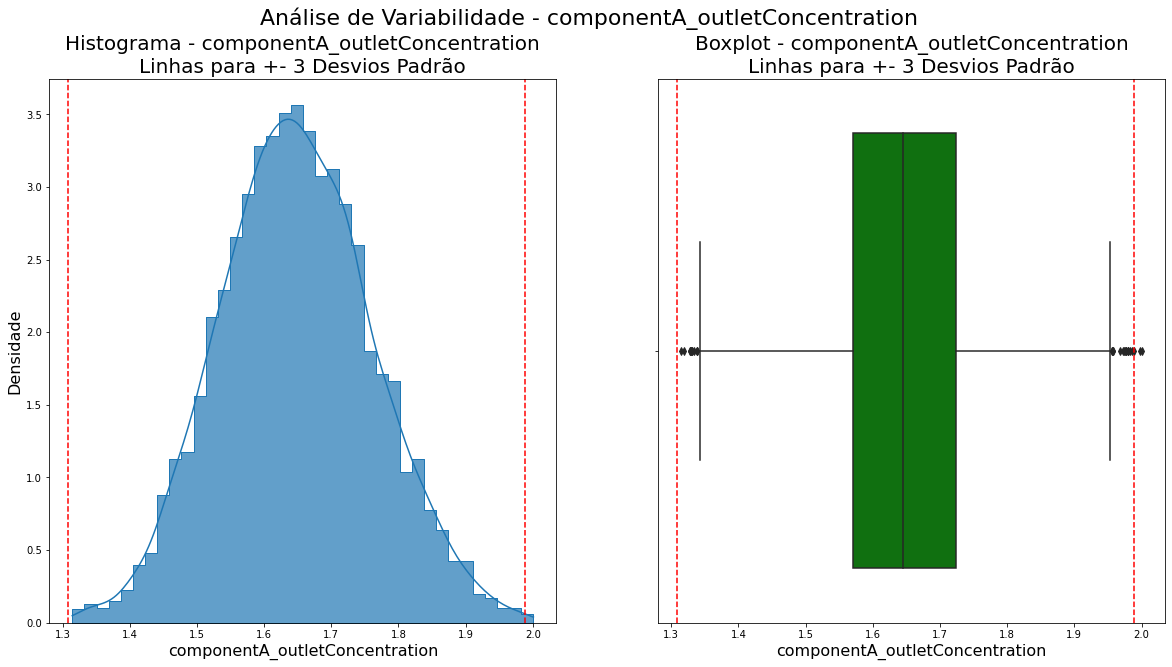

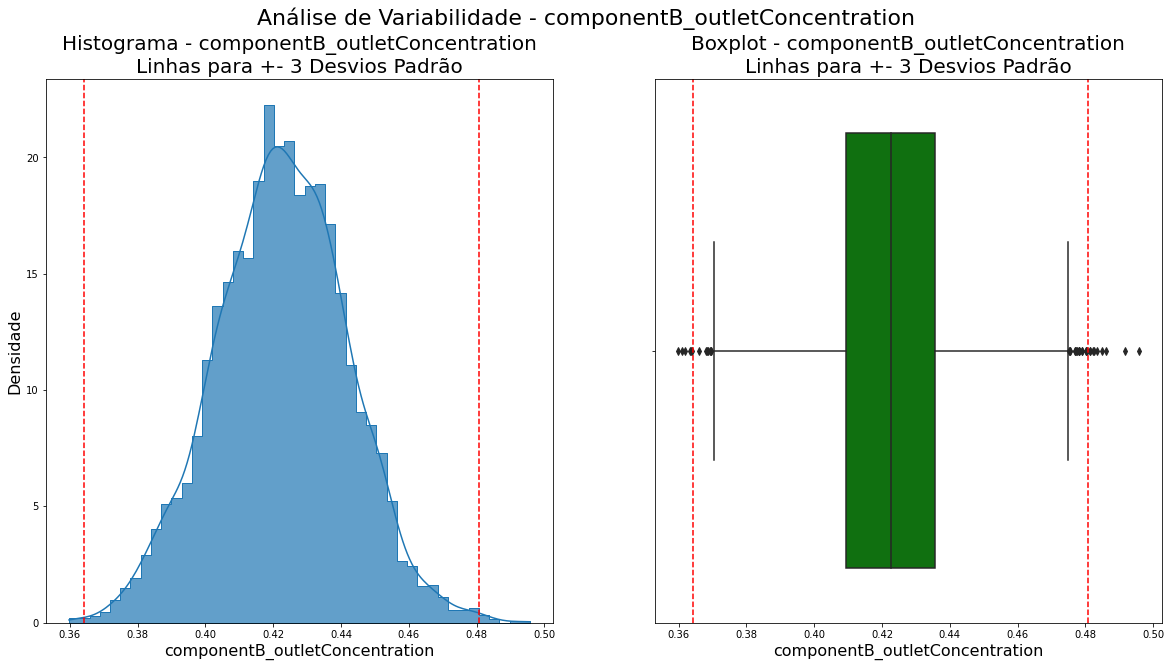

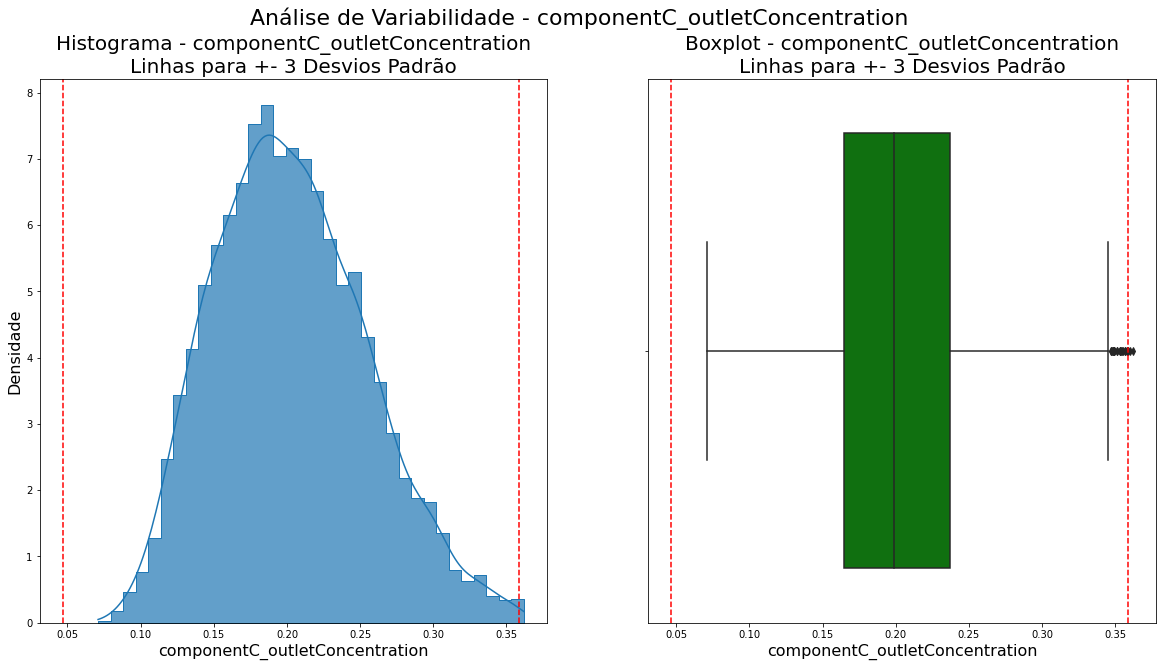

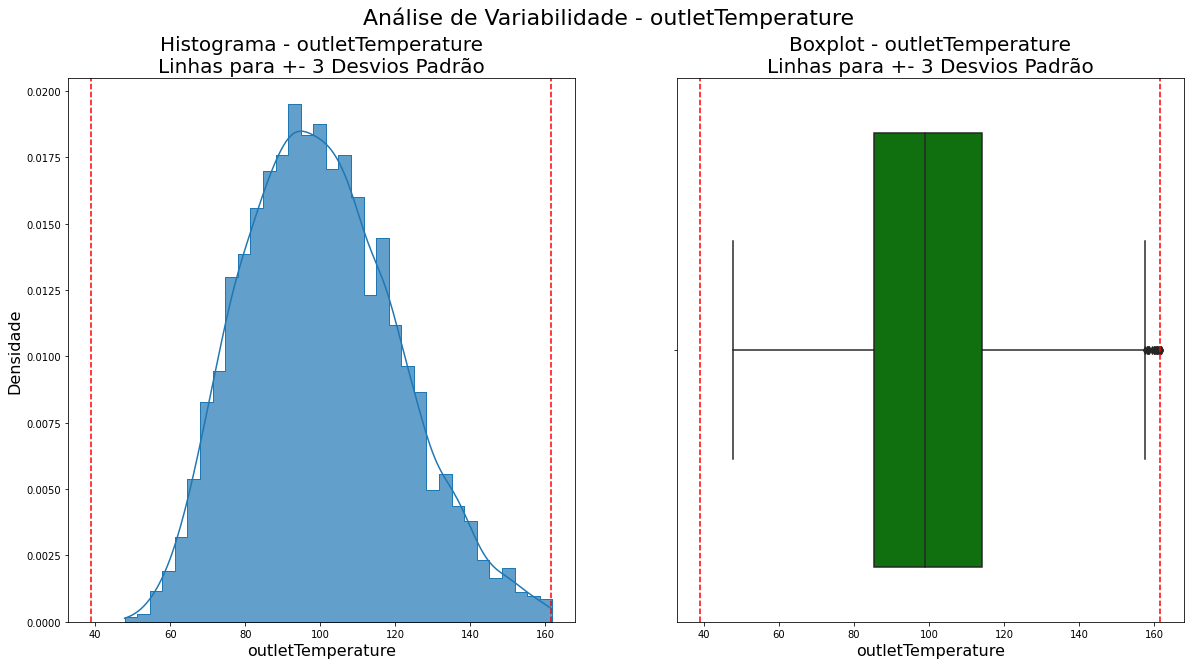

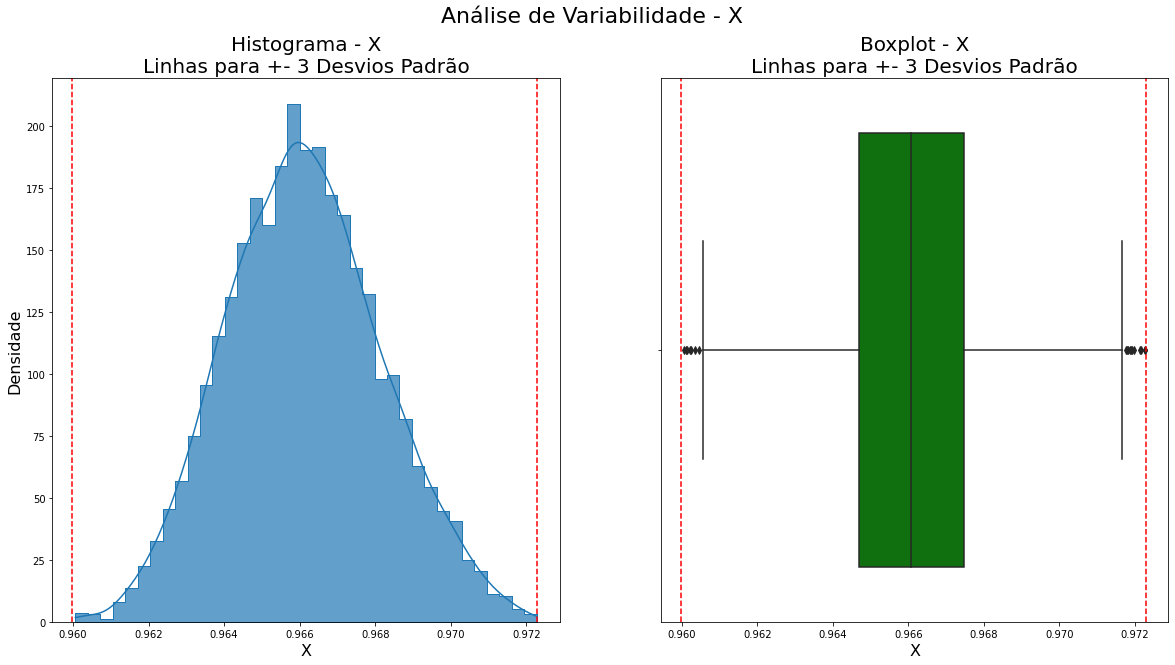

In [25]:
# checando as modificações
for column in columns_list:
  hist_boxplot(data_t, column)

In [26]:
# comparação da redução total do dataset
print('Dataset Original: %d linhas'%data.shape[0])
print('Data Tratado: %d linhas'%data_t.shape[0])
print('Redução Total: %.2f%%'%((data.shape[0]-data_t.shape[0])*100/data.shape[0]))

Dataset Original: 5000 linhas
Data Tratado: 4860 linhas
Redução Total: 2.80%


Conforme observado nos gráficos de histograma e *boxplot* existem alguns pontos ainda acima dos limites superior e abaixo do limite inferior. No entanto, todos se encontram dentro dos limites de +- desvios padrão, o que descarta a possibilidade de serem *outliers*

Dessa forma, conclui-se a etapa de pré-processamento dos dados. O próximo passo é estudar as correlações entre as variáveis de processo coletadas.

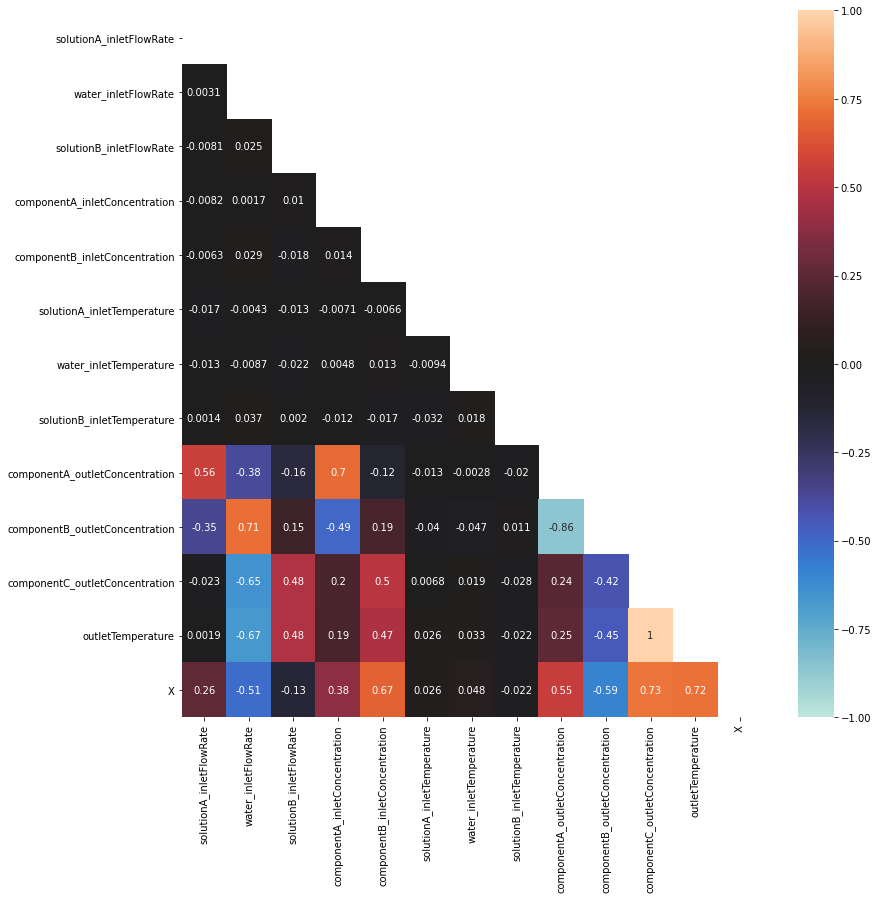

In [27]:
# calculando a matriz de correlação 
corr = data_t.corr()

# criando a máscara para construção da matriz
mask = np.triu(np.ones_like(corr, dtype=bool))

# plotando a matriz de correlação
plt.figure(figsize = (13,13))
sns.heatmap(corr, mask=mask, vmax=1, center=0, vmin = -1, annot = True)

Observando a matriz de correlação construídos, verifica-se que as variáveis de entrada do processo são indepedentes entre si, pois todos os coeficientes de correlação são bem próximos de zero.

Por outro lado, existem correlações significativas entre as variáveis de entrada e as variáveis de saída, conforme esperado pelos princípios físico químicos que guiam os processos reacionais.

Sobre as correlações observadas, podemos levantar as seguintes notas:

- **Concentração de Saída do Componente A**: influenciada positivamente pela vazão de entrada de componente A e pela concentração de componente A e negativamente pela vazão de entrada de água.
- **Concentração de Saída do Componente B**: influenciada positivamente vazão de entrada de água e negativamente pela vazão de componente A e pela concentração de componente A
- **Concentração de Saída do Componente C**: influenciada positivamente pela vazão de entrada de componente B e pela concentração de componente B na entrada. Influenciado negativamente pela vazão de entrada de água
- **Temperatura de Saída**: semelhante à observação feita para a concentração de saída do componente C
- **Conversão**: influenciada positivamente pela vazão de entrada do componente A, pela concentração de entrada do componente A e pelo concentração de entrada do componente B. Influenciada negativamente pela vazão de entrada de água e pela vazão de entrada do componente B.

É interessante observar existem correlações entre as próprias variáveis de saída. Com base nessa observação, podem-se traçar as seguintes observações:

- **Concentração de saída de componente A**: correlação negativa com a concentração de saída do componente B. Correlação positiva com a concentração de saída do componente C, com a temperatura de saída e com a conversão
- **Concentração de saída de componente B**: além da correlação já mencionada com, possui correlação negativa com a concentração de saída do componente C, com a temperatura de saída e com a conversão
- **Concentração de saída de componente C**: possui forte correlação positiva com a temperatura de saída e com a conversão

Depois de identificar as principais correlações entre as variáveis, vamos entender qual é o formato dessas relações, por meio dos gráficos de dispersão. Para tanto, será selecionado, para cada variável de interesse, as variáveis que apresentaram maior coeficiente de correlação.

### **2.1. Concentração de Saída  do Componente A** 

In [28]:
# estabelecimento do limite de correlação mínima que se deseja visualizar e seleção da variável
thres = 0.2
elec_var = 'componentA_outletConcentration'

def scatter_analysis(data, elec_var, thres):
  # cálculo da matriz de correlação e seleção da coluna correta
  corr_mat = pd.DataFrame(data.corr()[elec_var].reset_index())
  corr_mat.columns = ['var','corr']

  # seleção das variáveis que superam o limite mínimo de correlação
  elec_corr = list(corr_mat.loc[abs(corr_mat['corr'])>thres]['var'])

  # construção dos gráficos de dispersão
  ncol = 3
  nlin = len(elec_corr)//3 + 1
  i = 1

  plt.figure(figsize = (15,13))
  plt.subplots_adjust(wspace = 0.5, hspace = 0.3)
  for col in elec_corr:
    plt.subplot(nlin, ncol, i)
    plt.scatter(x = col, y = elec_var, marker = '.', data = data, color = 'black')
    plt.xlabel(col)
    plt.ylabel(elec_var)
    plt.grid()

    if i == 2:
      plt.title('Gráficos de Dispersão - ' + elec_var + 
                '\nNível de correlação mínima: ' + str(thres) + '\n',
                fontsize = 24)

    i += 1

  plt.show()

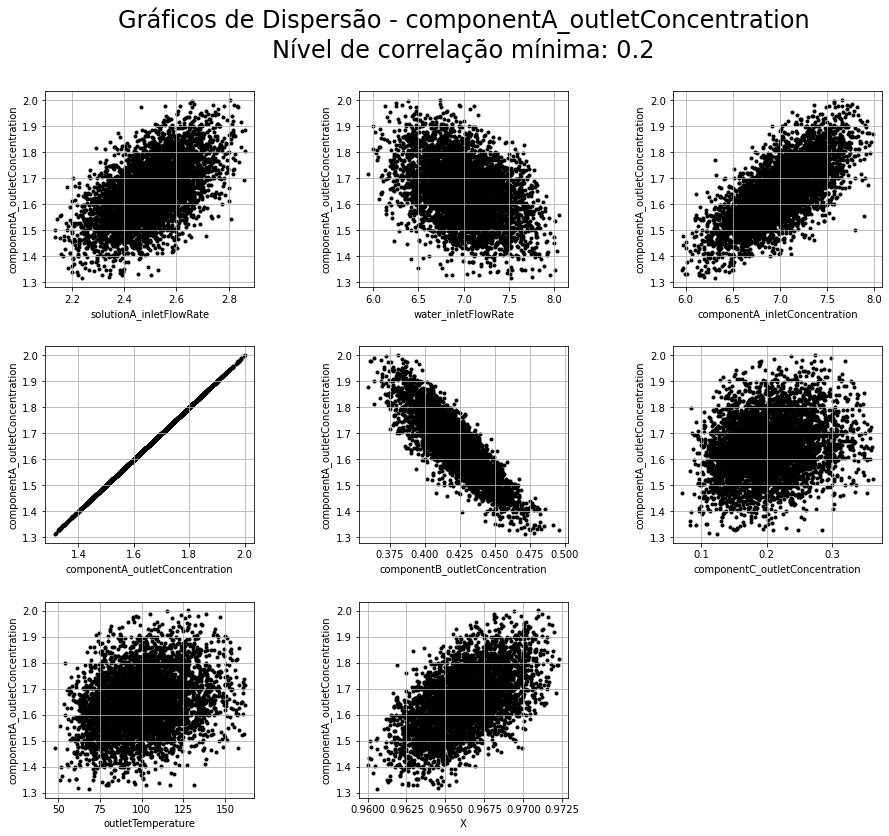

In [29]:
thres = 0.2
elec_var = 'componentA_outletConcentration'
scatter_analysis(data_t, elec_var, thres)

Com base nos gráficos acima, podemos ter as seguintes conclusões a respeito da concentração de saída do componente A:

- aumentando-se tanto a vazão de entrada do componente A como a concentração de entrada do componente A, espera-se um aumento aproximadamente proporcional da concentração de saída (direto do balanço de massa)
- aumentando-se a vazão de entrada de água, espera-se uma diluição e, portanto, a diminuição da concentração de saída
- o aumento da concentração de saída correlaciona-se com a diminuição da concentração de componente B (há maior consumo do reagente limitante). Consequentemente, espera-se o aumento da concentração do componente C, da temperatura de saída e da conversão

### **2.2. Concentração de Saída do Componente B**

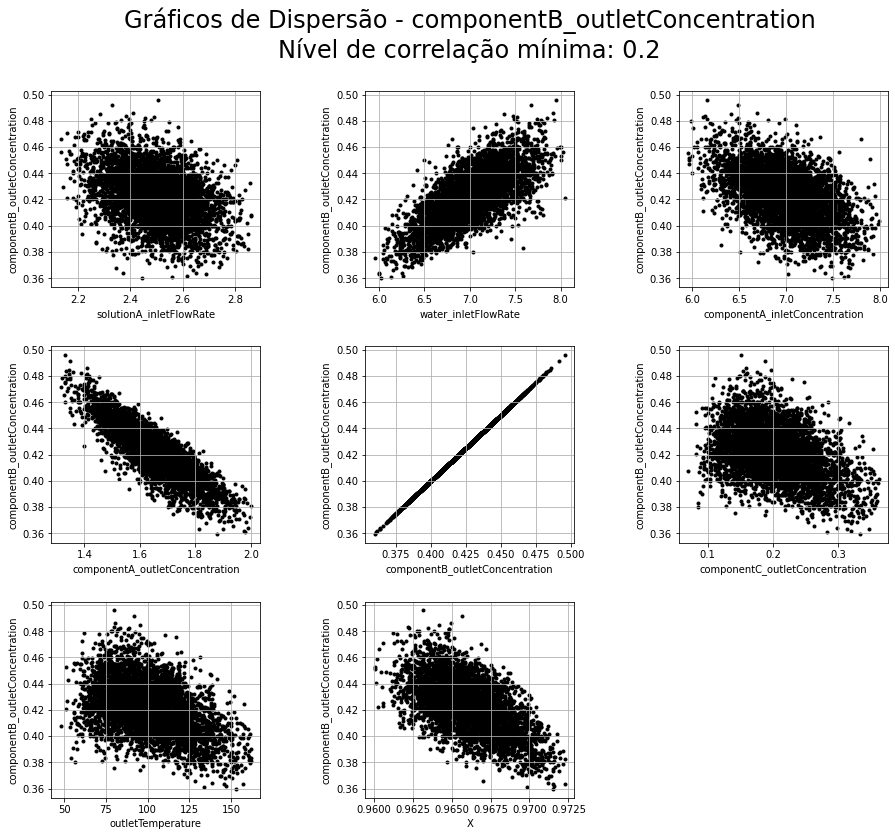

In [30]:
thres = 0.2
elec_var = 'componentB_outletConcentration'
scatter_analysis(data_t, elec_var, thres)

Os gráficos de dispersão apresentam as seguintes conclusões:

- O aumento da vazão de entrada do componente A e de sua concentração promove a diminuição da concentração de saída do componente B, visto que essas variáveis promovem o aumento da taxa de reação, aumentando o consumo desse componente (que é o limitante)
- o aumento da vazão de entrada de água promove o aumento da concentração de componente B na saída, visto que promove a diluição das concentrações no interior do reator, e assim o abaixamento da taxa de reação
- o aumento da concentração de saída do componente B está relacionado com a dimiuição da concentração de componente C, da temperatura de saída e da conversão, visto que se mais componente B está saindo do reator, então significa que a reação está ocorrendo com menor grau de avanço

### **2.3. Concentração de Saída do Componente C**

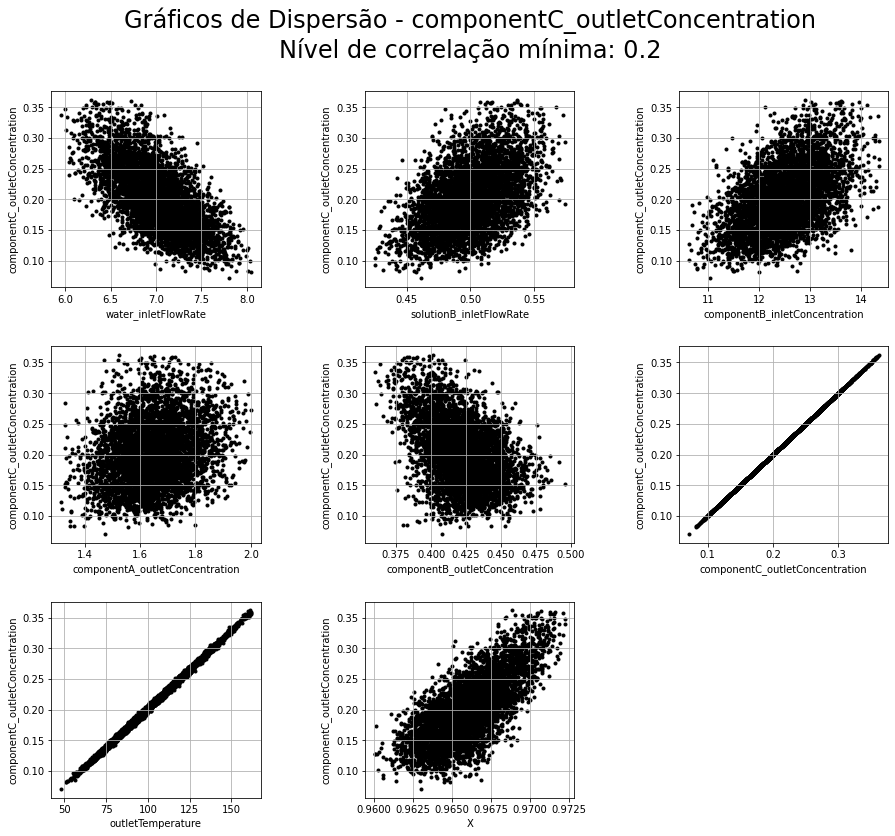

In [31]:
thres = 0.2
elec_var = 'componentC_outletConcentration'
scatter_analysis(data_t, elec_var, thres)

Os gráficos de dispersão mostram as seguintes conclusões para a concentração de saída do componente C
- o aumento da vazão de água na entrada promove a redução da concentração de componente C na saída, visto que a diluição dos componentes promove a redução da taxa de reação
- tanto o aumento da vazão de entrada do componente B quanto sua concentração promovem o aumento da concentração de saída do componente C, visto que ambas as variáveis promovem o aumento da taxa de reação (componente B é o limitante)
- o aumento da concentração do componente C está correlacionado com o aumento da concentração do componente A na saída, visto que se mais componente A é adicionado no reator, então maior será a taxa de reação e portanto, mais produto será produzido.
- também se pode observar uma correlação negativa com a concentração de componente B, visto que se mais componente C está saindo do reator, mais componente B será consumido e, portanto, menor será a concentração de B na saída
- pode-se notar que a concentração de componente C está bem correlacionada com a temperatura de saída, o que apresentar uma oportunidade de controle de processo, visto que, geralmente, a medida da temperatura é mais fácil que a medida da concentração.
- finalmente, o aumento da concentração está relacionado com o aumento da conversão, visto que uma maior conversão significa maior produção de componente C pela reação química. 

### **2.4. Temperatura de Saída**

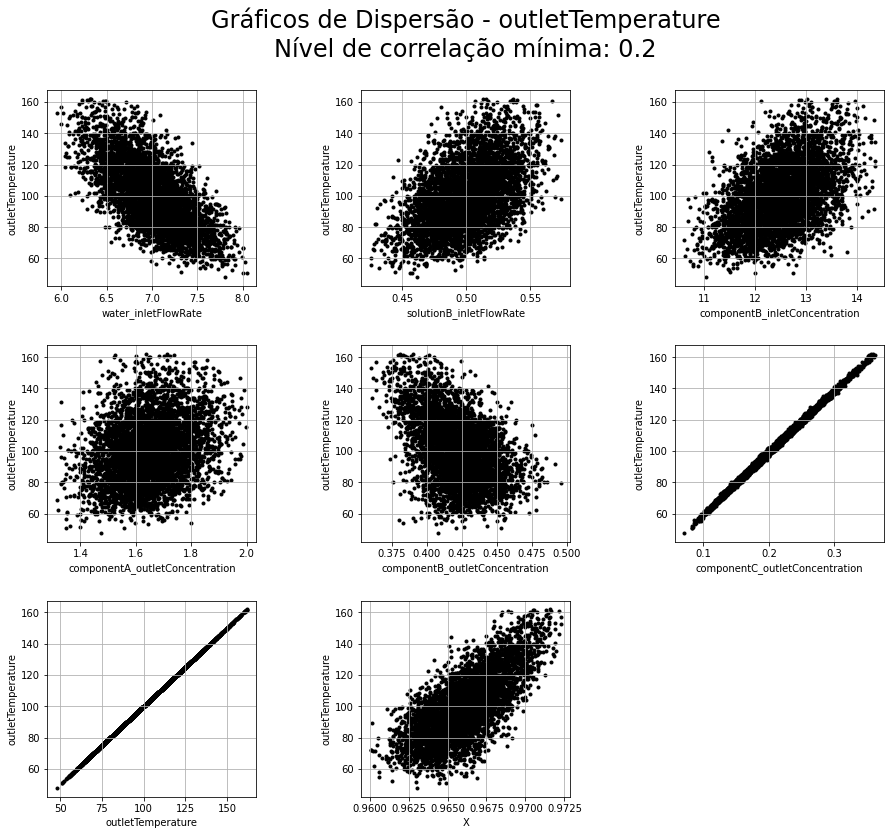

In [32]:
thres = 0.2
elec_var = 'outletTemperature'
scatter_analysis(data_t, elec_var, thres)

As conclusões obtidas para a temperatura de saída seguem a mesma linha de raciocínio das obtidos devido principalmente ao alto grau de correlação existente entre essas duas variáveis.

### **2.5. Conversão**

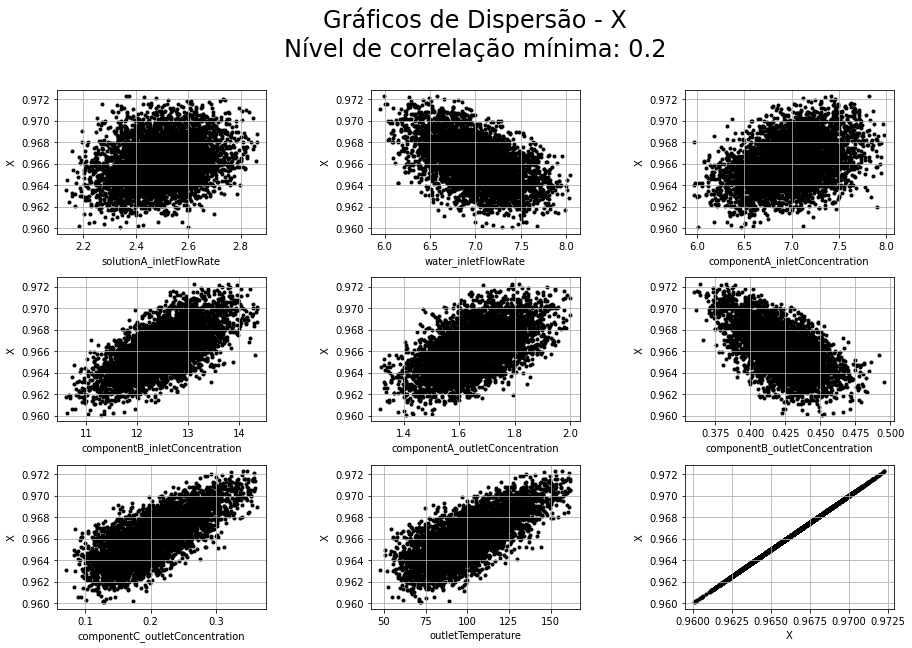

In [33]:
thres = 0.2
elec_var = 'X'
scatter_analysis(data_t, elec_var, thres)

As conclusões que podem ser tiradas para o caso da correlação da conversão com as outras variáveis são análogas àquelas tiradas sobre a relação dessas variáveis com a concentração do componente B na saída.

## **3. Análise de Controle Estatístico de Processo**

Esta seção é dedicada para a análise do processo do ponto de vista do controle estatístico de processo.

O controle estatístico de processo é uma ferramenta utilizada para entender se um processo está sob controle estatístico. Diz-se que um processo está sob controle quando as variações observadas se encontram dentro dos limites estatísticos, que representam a variação máxima considerada como *natural*.

Caso as variações sejam maiores que esses limites, diz-se que os processos estão sob influência de causas *especiais*, ou seja, existe uma influência externa que está provocando a anomalia no processo.

Nesse processo, vamos simular que a aquisição de dados relacionados à qualidade do produto seja realizada em laboratório, de 15 em 15 minutos. Ou seja, para cada hora de produção, 4 amostras são coletadas e analisadas.

### **3.1. Concentração de Saída - Componente A**

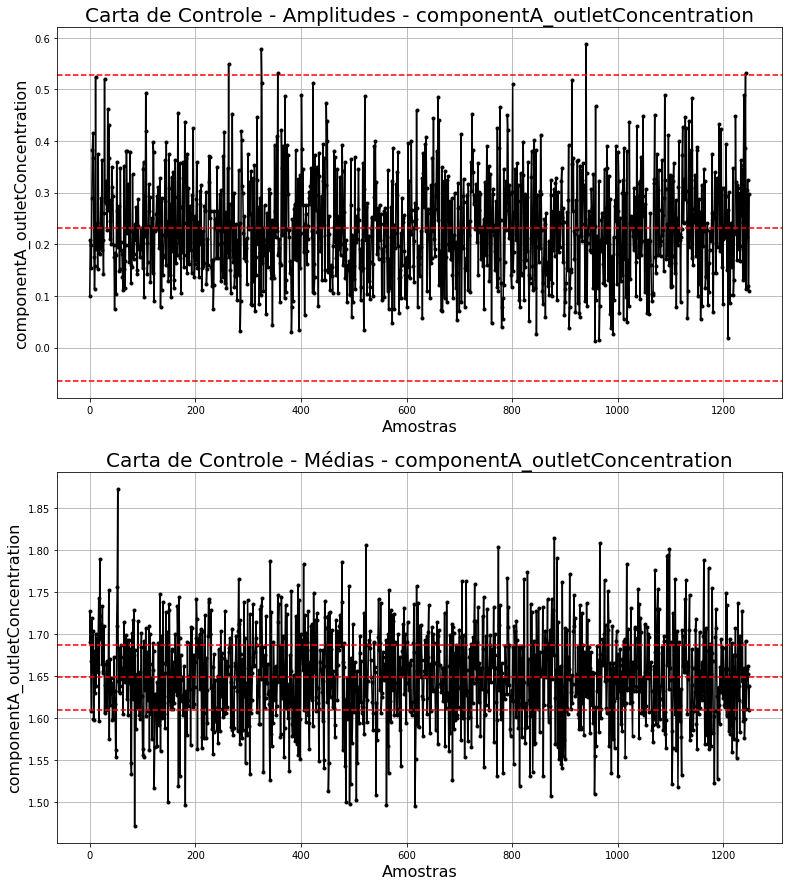

In [34]:
var_name = 'componentA_outletConcentration'

results_A_out = control_chart(data_t, var_name, n = 4)

Como se pode observar, há muitos pontos referentes à concentração de saída da componente A que se encontram fora dos limites estatísticos de controle.

Isso mostra que o processo se encontra instável, sujeito a muitas causas especiais que estão promovendo variações acima dos limites aceitáveis para esse processo.

### **3.2. Concentração de Saída - Componente B**

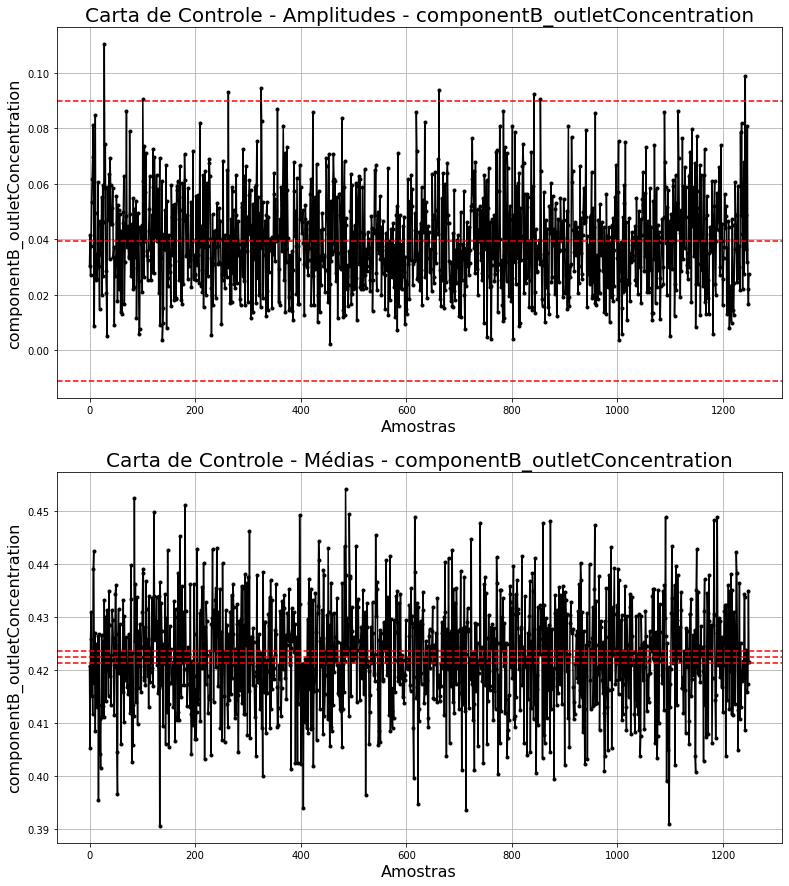

In [35]:
var_name = 'componentB_outletConcentration'

results_B_out = control_chart(data_t, var_name, n = 4)


### **3.3. Concentração de Saída - Componente C**

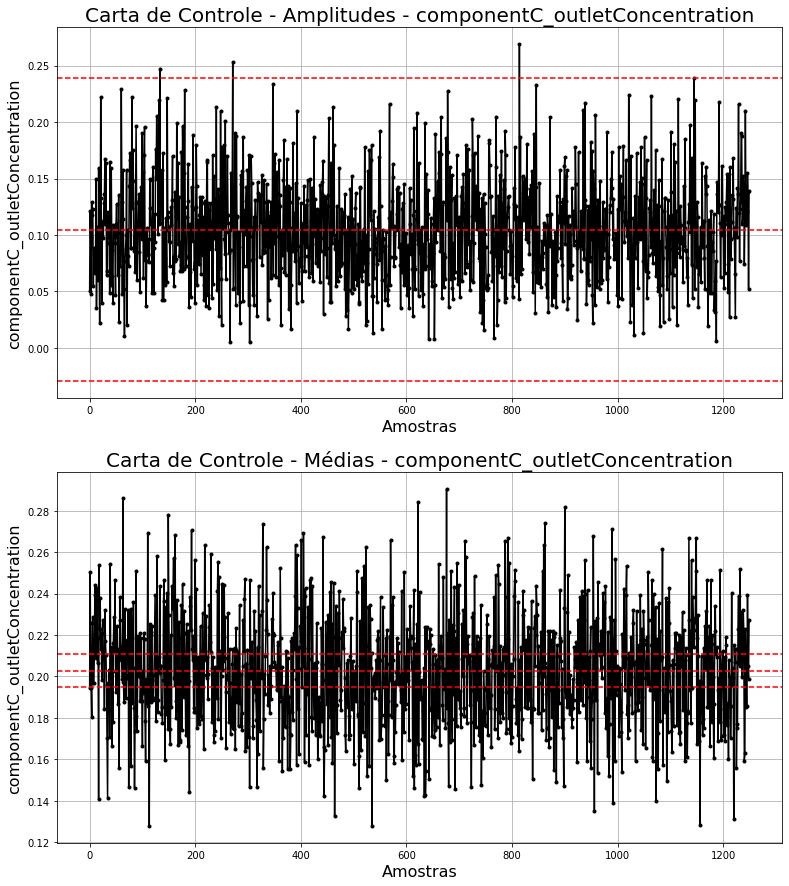

In [36]:
var_name = 'componentC_outletConcentration'

results_C_out = control_chart(data_t, var_name, n = 4)

## **4. Estratégia de Modelagem e Pré-processamento**

Verifica-se que todas as variáveis de saída importantes, que são as concentrações de saída de A, B e C mostram um processo totalmente instável, pois existem muitos pontos fora dos limites de controle estatístico de processo.

Nesse caso, não estudaremos a temperatura de saída, devido à sua alta correlação com a concentração de saída do componente C. Como serão três variáveis de saída, três modelos de clusterização serão classificados, no intuito de entender os padrões de variáveis de entrada que promovem a instabilidade no processo.

### **4.1. Criação de Novas Variáveis**

Nessa etapa será criada uma variável indicadora do controle estatístico de processo, seguindo a seguinte a lógica:

- 0 - para dados dentro dos limites de controle estatístico
- 1 - para dados acima do limite superior ou abaixo do limite inferior de controle estatístico

In [37]:
# criação de novas variáveis
def new_feat(data, keys_values, col_name):

  # extração dos valores do dicionários
  LIC_X = keys_values['LIC_X']
  LSC_X = keys_values['LSC_X']

  # criação de nova variável indicativa da situação de controle estatístico
  data['CONTROL'] = int(0)
  data.loc[data[col_name] > LSC_X,'CONTROL'] = int(1)
  data.loc[data[col_name] < LIC_X,'CONTROL'] = int(1)

  # reiniciando índices
  data = data.reset_index()
  data.drop(['index'], axis = 1, inplace = True)

  return data

In [38]:
# tratamento de dados para concentração de A na saída
col_name = 'componentA_outletConcentration'
to_drop = ['componentB_outletConcentration', 'componentC_outletConcentration', 
           'outletTemperature']
dataA = data_t.copy()
dataA.drop(to_drop, axis = 1, inplace = True)

dataA = new_feat(dataA, results_A_out, col_name)
dataA['CONTROL'].value_counts()

1    3575
0    1285
Name: CONTROL, dtype: int64

In [39]:
# tratamento de dados para concentração de B na saída
col_name = 'componentB_outletConcentration'
to_drop = ['componentA_outletConcentration', 'componentC_outletConcentration','outletTemperature']
dataB = data_t.copy()
dataB.drop(to_drop, axis = 1, inplace = True)

dataB = new_feat(dataB, results_B_out, col_name)
dataB['CONTROL'].value_counts()

1    4623
0     237
Name: CONTROL, dtype: int64

In [40]:
# tratamento de dados para concentração de C na saída
col_name = 'componentC_outletConcentration'
to_drop = ['componentA_outletConcentration', 'componentB_outletConcentration', 'outletTemperature']
dataC = data_t.copy()
dataC.drop(to_drop, axis = 1, inplace = True)

dataC = new_feat(dataC, results_C_out, col_name)
dataC['CONTROL'].value_counts()

1    4303
0     557
Name: CONTROL, dtype: int64

### **4.2. Aplicação de Escalonamento de Variáveis**